In [1]:
!pip install pyspark

# Load thư viện pyspark

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when

In [3]:
# Init SparkSession
spark = SparkSession.builder.appName("Pyspark Tutorial").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","10g").getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/20 17:03:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Đọc dữ liệu

In [4]:
df = spark.read.csv("/kaggle/input/weather-prediction-rnn-and-cnn/weather_dataset.csv", header=True, inferSchema=True)

In [5]:
df.show(5)

25/05/20 17:04:11 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------------+-------+----+--------+----------------+-------------------+----------+-------------------+------+------+------+--------------+--------+--------+-----------+--------+-----------+-----------+---------+---------+--------+-----+-----------+-----------+-----------+-----------+-----------+-----------+----------+----------+------+---------+---+--------+--------+------------+--------------+
|location_name|country| lat|     lon|           tz_id|          localtime|      date|               time|temp_c|temp_f|is_day|condition_text|wind_mph|wind_kph|wind_degree|wind_dir|pressure_mb|pressure_in|precip_mm|precip_in|humidity|cloud|feelslike_c|feelslike_f|windchill_c|windchill_f|heatindex_c|heatindex_f|dewpoint_c|dewpoint_f|vis_km|vis_miles| uv|gust_mph|gust_kph|will_it_rain|chance_of_rain|
+-------------+-------+----+--------+----------------+-------------------+----------+-------------------+------+------+------+--------------+--------+--------+-----------+--------+-----------+------

In [6]:
df.createOrReplaceTempView("weather_dataset")

# Kiểm tra null

In [7]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-------------+-------+---+---+-----+---------+----+----+------+------+------+--------------+--------+--------+-----------+--------+-----------+-----------+---------+---------+--------+-----+-----------+-----------+-----------+-----------+-----------+-----------+----------+----------+------+---------+---+--------+--------+------------+--------------+
|location_name|country|lat|lon|tz_id|localtime|date|time|temp_c|temp_f|is_day|condition_text|wind_mph|wind_kph|wind_degree|wind_dir|pressure_mb|pressure_in|precip_mm|precip_in|humidity|cloud|feelslike_c|feelslike_f|windchill_c|windchill_f|heatindex_c|heatindex_f|dewpoint_c|dewpoint_f|vis_km|vis_miles| uv|gust_mph|gust_kph|will_it_rain|chance_of_rain|
+-------------+-------+---+---+-----+---------+----+----+------+------+------+--------------+--------+--------+-----------+--------+-----------+-----------+---------+---------+--------+-----+-----------+-----------+-----------+-----------+-----------+-----------+----------+----------+------+--

# Kiểm tra unique

In [8]:
from pyspark.sql.functions import countDistinct

for col_name in df.columns:
    unique_count = df.select(countDistinct(col_name)).collect()[0][0]
    print(f"Column '{col_name}' has {unique_count} unique values.")


Column 'location_name' has 63 unique values.


Column 'country' has 1 unique values.


Column 'lat' has 62 unique values.


Column 'lon' has 62 unique values.


Column 'tz_id' has 2 unique values.


Column 'localtime' has 255 unique values.


Column 'date' has 367 unique values.


Column 'time' has 8808 unique values.


Column 'temp_c' has 425 unique values.


Column 'temp_f' has 740 unique values.


Column 'is_day' has 2 unique values.


Column 'condition_text' has 21 unique values.


Column 'wind_mph' has 310 unique values.


Column 'wind_kph' has 456 unique values.


Column 'wind_degree' has 361 unique values.


Column 'wind_dir' has 16 unique values.


Column 'pressure_mb' has 67 unique values.


Column 'pressure_in' has 175 unique values.


Column 'precip_mm' has 1010 unique values.


Column 'precip_in' has 119 unique values.


Column 'humidity' has 92 unique values.


Column 'cloud' has 101 unique values.


Column 'feelslike_c' has 506 unique values.


Column 'feelslike_f' has 876 unique values.


Column 'windchill_c' has 442 unique values.


Column 'windchill_f' has 771 unique values.


Column 'heatindex_c' has 486 unique values.


Column 'heatindex_f' has 839 unique values.


Column 'dewpoint_c' has 356 unique values.


Column 'dewpoint_f' has 622 unique values.


Column 'vis_km' has 22 unique values.


Column 'vis_miles' has 7 unique values.


Column 'uv' has 11 unique values.


Column 'gust_mph' has 521 unique values.


Column 'gust_kph' has 792 unique values.


Column 'will_it_rain' has 2 unique values.


Column 'chance_of_rain' has 3 unique values.


In [9]:
df = df.drop('country','lat','lon', 'date','tz_id','localtime','temp_f','wind_kph', 'feelslike_c','feelslike_f',
        'pressure_in','heatindex_f','precip_in','windchill_f', 'dewpoint_f','vis_miles','gust_kph')

In [10]:
df.columns

['location_name',
 'time',
 'temp_c',
 'is_day',
 'condition_text',
 'wind_mph',
 'wind_degree',
 'wind_dir',
 'pressure_mb',
 'precip_mm',
 'humidity',
 'cloud',
 'windchill_c',
 'heatindex_c',
 'dewpoint_c',
 'vis_km',
 'uv',
 'gust_mph',
 'will_it_rain',
 'chance_of_rain']

# Encoder for location, condition, wind_dir

In [11]:
from pyspark.ml.feature import StringIndexer

indexer_location = StringIndexer(inputCol="location_name", outputCol="location")
indexer_condition = StringIndexer(inputCol="condition_text", outputCol="condition")
indexer_wind_dir = StringIndexer(inputCol="wind_dir", outputCol="wind_direct")

df = indexer_location.fit(df).transform(df)
df = indexer_condition.fit(df).transform(df)
df = indexer_wind_dir.fit(df).transform(df)

df.show(5)


+-------------+-------------------+------+------+--------------+--------+-----------+--------+-----------+---------+--------+-----+-----------+-----------+----------+------+---+--------+------------+--------------+--------+---------+-----------+
|location_name|               time|temp_c|is_day|condition_text|wind_mph|wind_degree|wind_dir|pressure_mb|precip_mm|humidity|cloud|windchill_c|heatindex_c|dewpoint_c|vis_km| uv|gust_mph|will_it_rain|chance_of_rain|location|condition|wind_direct|
+-------------+-------------------+------+------+--------------+--------+-----------+--------+-----------+---------+--------+-----+-----------+-----------+----------+------+---+--------+------------+--------------+--------+---------+-----------+
|     Chau Doc|2024-04-25 00:00:00|  30.0|     0|         Clear|     9.2|        191|     SSW|     1008.0|      0.0|      65|   19|       30.0|       34.0|      22.7|  10.0|0.0|    12.9|           0|             0|    13.0|      4.0|       12.0|
|     Chau Doc|2

# Tính mối tương quan giữa các biến

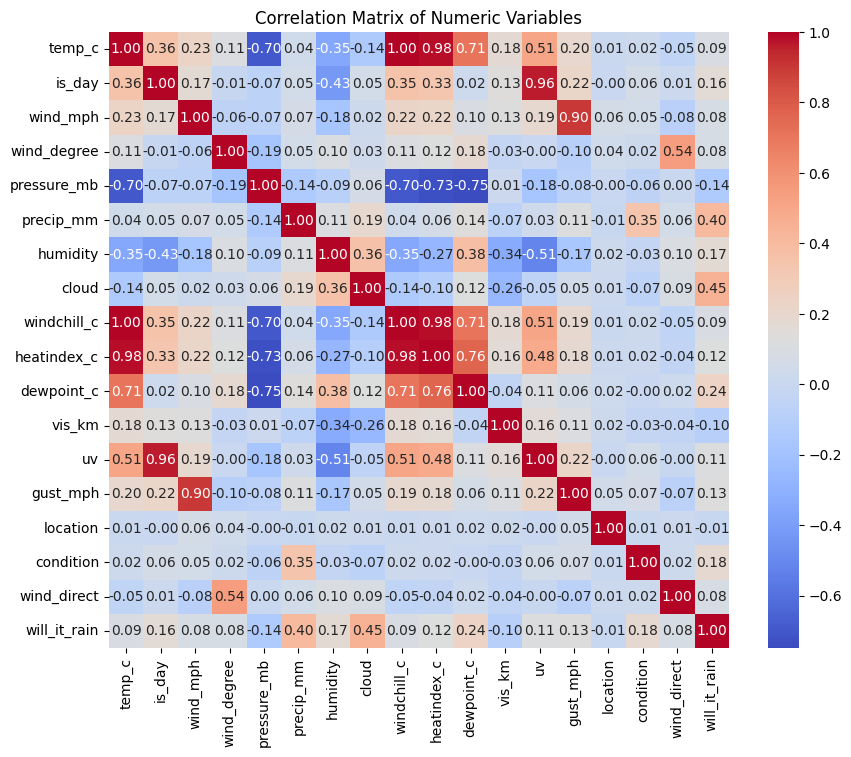

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_columns = ['temp_c',
 'is_day',
 'wind_mph',
 'wind_degree',
 'pressure_mb',
 'precip_mm',
 'humidity',
 'cloud',
 'windchill_c',
 'heatindex_c',
 'dewpoint_c',
 'vis_km',
 'uv',
 'gust_mph',
 'location',
 'condition',
 'wind_direct',
 'will_it_rain',]

correlation_matrix = df.select(numeric_columns).toPandas().corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Variables')
plt.show()


# Dataset dự đoán nhiệt độ

## Chuẩn bị dữ liệu đa tỉnh thành

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Input, BatchNormalization
import tensorflow as tf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, countDistinct, first
from pyspark.sql import functions as F

2025-05-20 17:05:23.326279: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747760723.589200      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747760723.662375      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [14]:
df_temp = df.select(
    'location_name', 'time', 'temp_c', 'is_day', 'wind_mph', 'wind_degree', 
    'precip_mm', 'humidity', 'cloud', 'vis_km', 'uv', 'gust_mph', 'condition_text', 'wind_dir'
)

In [15]:
# [Existing Code: Data Preparation with Spark]
# Chuyển đổi dữ liệu thành định dạng wide format (mỗi tỉnh là một cột)
pivot_df = df_temp.groupBy("time").pivot("location_name").agg(F.first("temp_c"))

# Thêm các đặc trưng meta (giữ nguyên qua các tỉnh)
meta_features = df_temp.drop("location_name").groupBy("time").agg(
    F.first("is_day").alias("is_day"),
    F.first("wind_mph").alias("wind_mph"),
    F.first("wind_degree").alias("wind_degree"),
    F.first("precip_mm").alias("precip_mm"),
    F.first("humidity").alias("humidity"),
    F.first("vis_km").alias("vis_km"),
    F.first("gust_mph").alias("gust_mph"),
    F.first("uv").alias("uv"),
    F.first("condition_text").alias("condition"),
    F.first("wind_dir").alias("wind_direct")
)

# Join dữ liệu nhiệt độ với đặc trưng meta
final_df = pivot_df.join(meta_features, on="time", how="inner")

In [16]:
from pyspark.ml.feature import Imputer

# Danh sách các cột nhiệt độ từ các tỉnh (sau pivot)
temp_columns = [col for col in final_df.columns if col not in ['time', 'is_day', 'wind_mph', 'wind_degree',
                                                               'precip_mm', 'humidity', 'vis_km', 'gust_mph',
                                                               'uv', 'condition', 'wind_direct']]

# Thực hiện xử lý NaN trên tất cả các cột (nhiệt độ + meta)
imputer = Imputer(
    inputCols=temp_columns + ["wind_mph", "wind_degree", "precip_mm", "humidity", "vis_km", "gust_mph", "uv"],
    outputCols=temp_columns + ["wind_mph", "wind_degree", "precip_mm", "humidity", "vis_km", "gust_mph", "uv"]
).setStrategy("mean")

final_df_imputed = imputer.fit(final_df).transform(final_df)

# Chuyển đổi sang Pandas DataFrame với datetime index
pandas_df = final_df_imputed.orderBy("time").toPandas()
pandas_df['time'] = pd.to_datetime(pandas_df['time'])
pandas_df.set_index('time', inplace=True)
ts_data = pandas_df.drop(columns=['condition', 'wind_direct'])  # Loại bỏ cột không phải số

## Tạo cửa sổ thời gian (time windows)

In [17]:
# [Inserted Snippet 1: Time Window Function]
def create_time_windows_optimized(data, window_size, horizon, batch_size=1000):
    total_samples = len(data) - window_size - horizon
    X_batches = []
    y_batches = []
    
    for start_idx in range(0, total_samples, batch_size):
        end_idx = min(start_idx + batch_size, total_samples)
        X_batch = np.zeros((end_idx - start_idx, window_size, data.shape[1]))
        y_batch = np.zeros((end_idx - start_idx, horizon, 63))
        
        for i in range(start_idx, end_idx):
            X_batch[i - start_idx] = data.iloc[i:i + window_size].values
            y_batch[i - start_idx] = data.iloc[i + window_size:i + window_size + horizon, :63].values
        
        X_batches.append(X_batch)
        y_batches.append(y_batch)
    
    return np.concatenate(X_batches), np.concatenate(y_batches)

# Tạo dữ liệu
window_size = 24
horizon = 24
X, y = create_time_windows_optimized(ts_data, window_size, horizon, batch_size=500)

# Chuẩn hóa dữ liệu
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Reshape X và y để chuẩn hóa
X_flat = X.reshape(-1, X.shape[2])
X_scaled = scaler_X.fit_transform(X_flat).reshape(X.shape)

y_flat = y.reshape(-1, y.shape[2])
y_scaled = scaler_y.fit_transform(y_flat).reshape(y.shape)

## Build the CNN Model

In [18]:
# [Inserted Snippet 2: Train-Test Split]
X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Cập nhật mô hình CNN cho dự báo đa bước
n_features = X.shape[2]
model = Sequential([
    Input(shape=(window_size, n_features)),
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(horizon * 63)  # Đầu ra: horizon * 63 tỉnh
])

# Reshape đầu ra trong mô hình
model.add(tf.keras.layers.Reshape((horizon, 63)))

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)

X_train shape: (6132, 24, 71)
y_train shape: (6132, 24, 63)


2025-05-20 17:06:07.470691: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.4034 - val_loss: 0.1295
Epoch 2/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1360 - val_loss: 0.1137
Epoch 3/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1194 - val_loss: 0.1049
Epoch 4/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1100 - val_loss: 0.0941
Epoch 5/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1004 - val_loss: 0.0861
Epoch 6/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0922 - val_loss: 0.0938
Epoch 7/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0936 - val_loss: 0.0813
Epoch 8/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0855 - val_loss: 0.0738
Epoch 9/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0812 - val_loss: 0.0741
Epoch 10/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0784 - val_loss: 0.0714
Epoch 11/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0735 - val_loss: 0.0761
Epoch 12/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

## Dự báo và đánh giá

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/tmp/ipykernel_35/2488576397.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_times = pd.date_range(start=start_time, periods=24, freq='H')


Ap Tan Qui Kinh: MSE=0.64, MAE=0.60°C


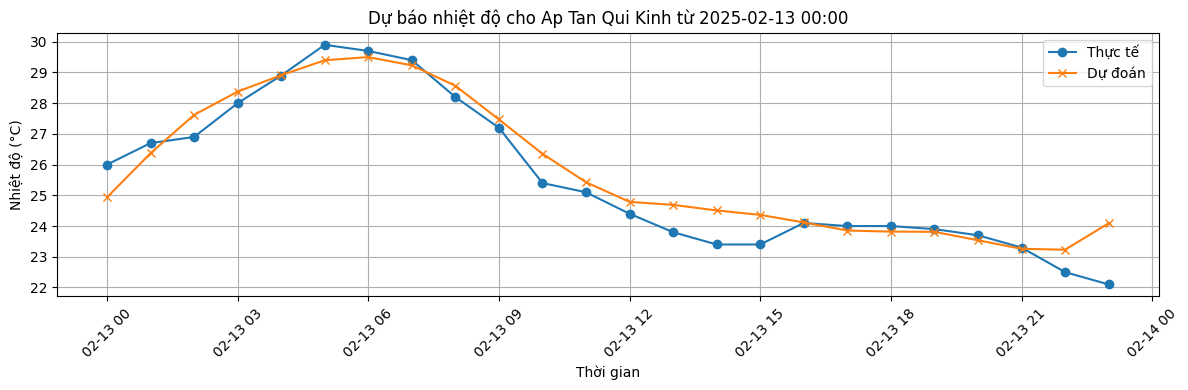

Atba Village: MSE=0.64, MAE=0.61°C


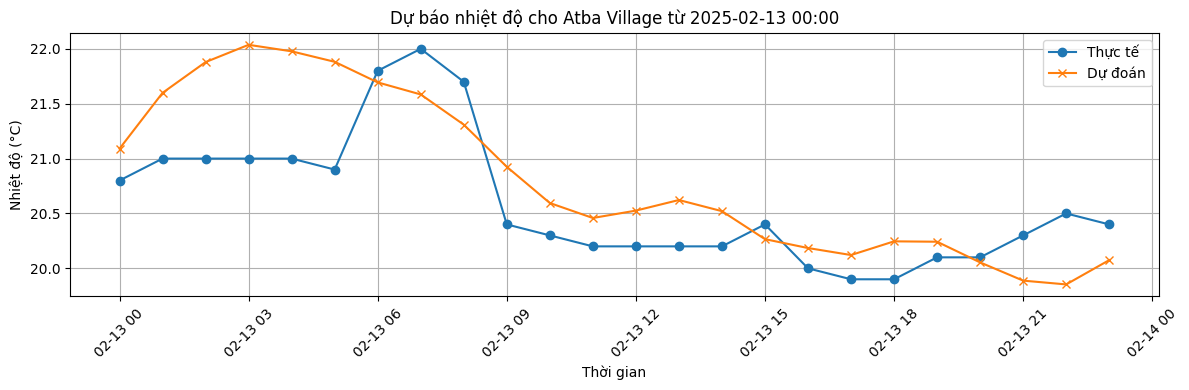

Bac Can: MSE=1.60, MAE=0.98°C


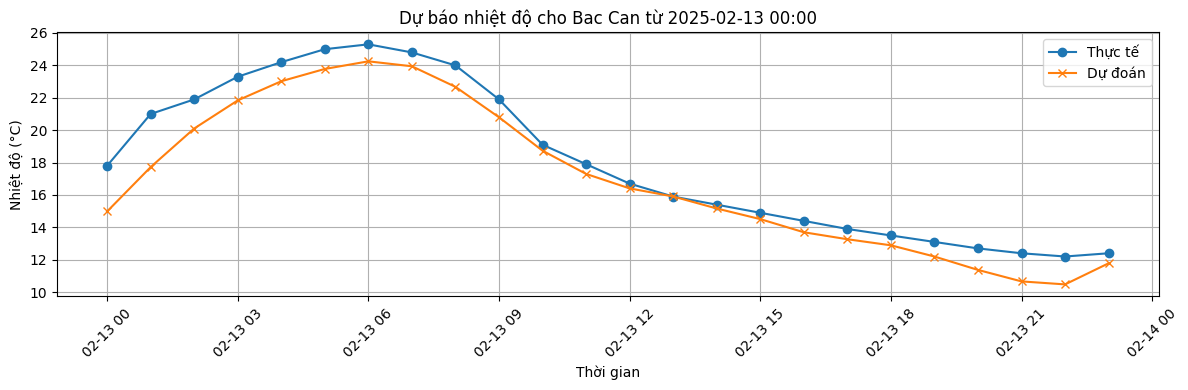

Bac Giang: MSE=1.08, MAE=0.80°C


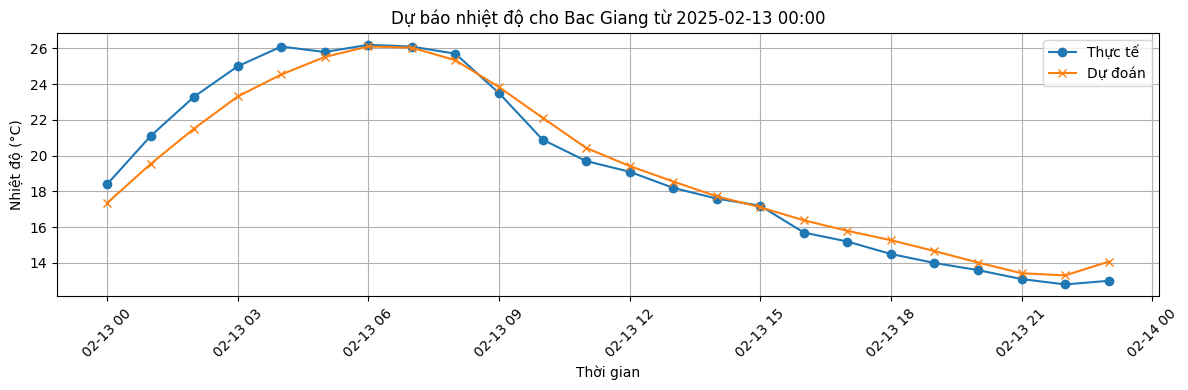

Bac Lieu: MSE=0.53, MAE=0.55°C


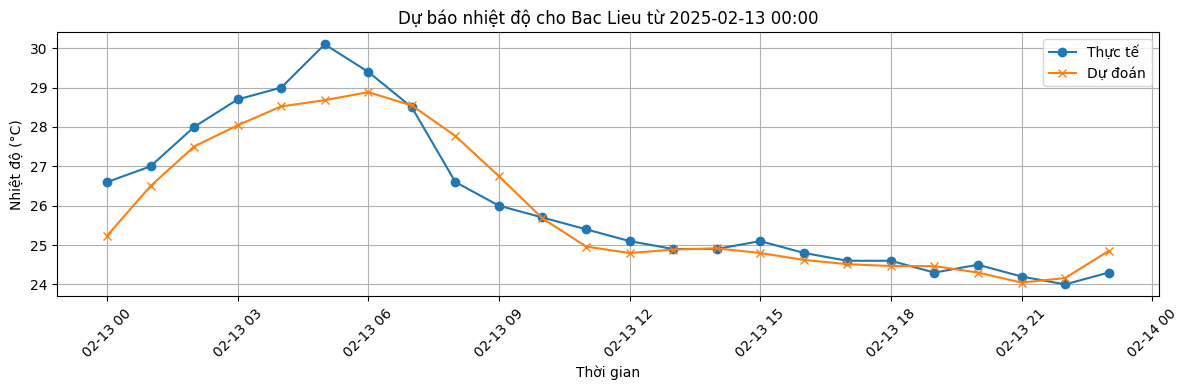

Bac Ninh: MSE=1.08, MAE=0.80°C


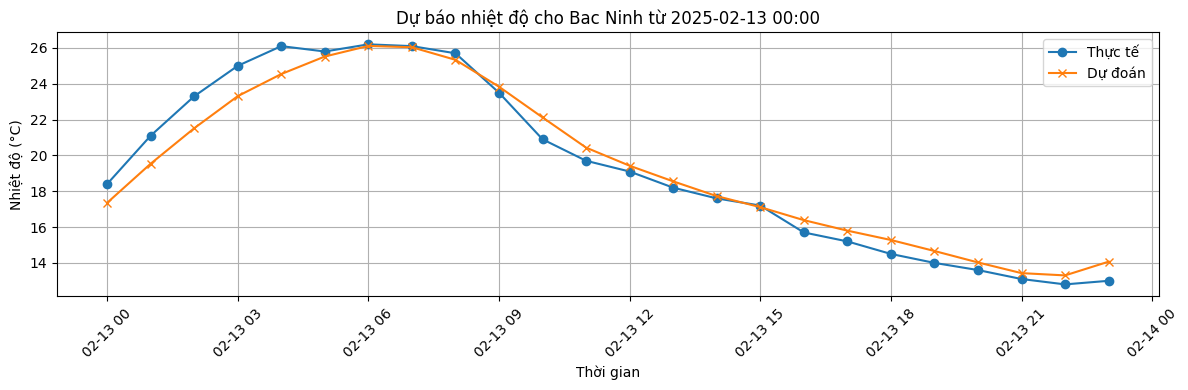

Ben Tre: MSE=0.61, MAE=0.59°C


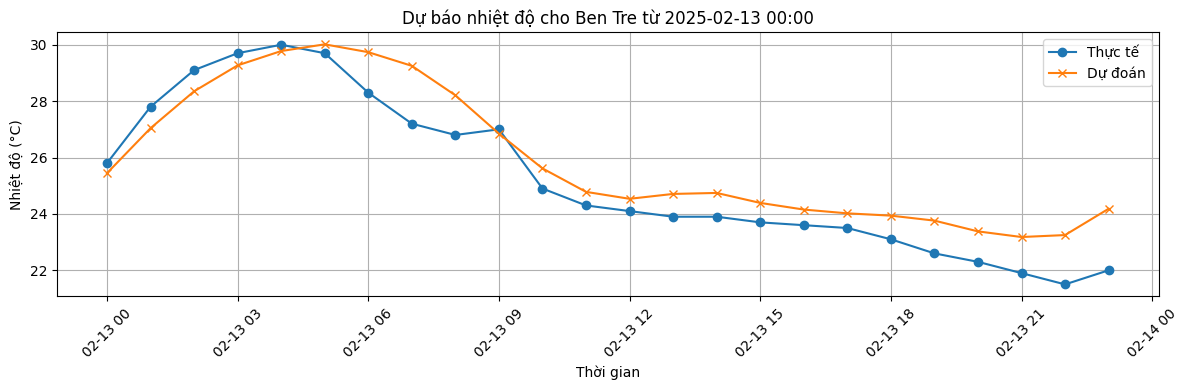

Bien Hoa: MSE=0.54, MAE=0.56°C


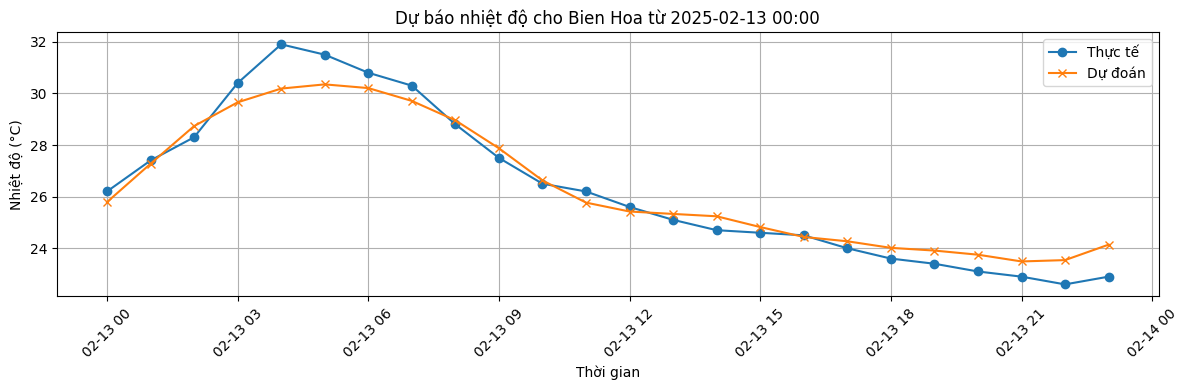

Buon Me Thuot: MSE=0.92, MAE=0.73°C


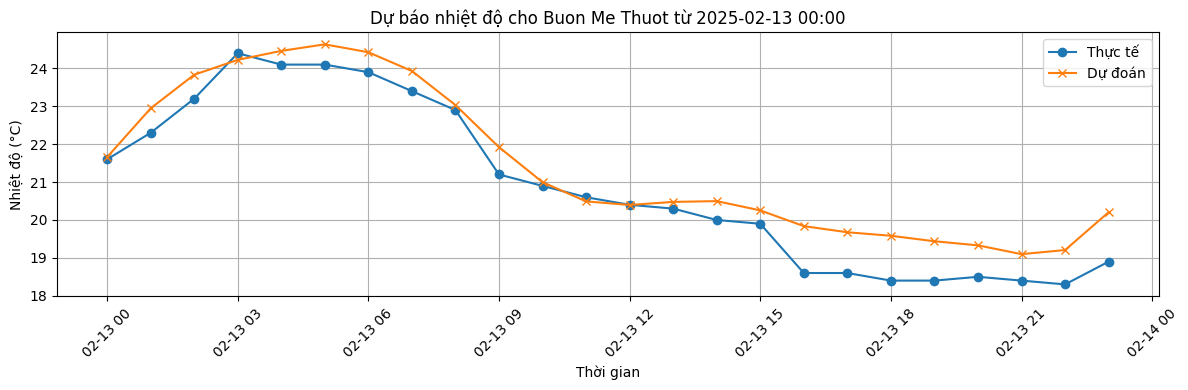

Ca Mau: MSE=0.61, MAE=0.58°C


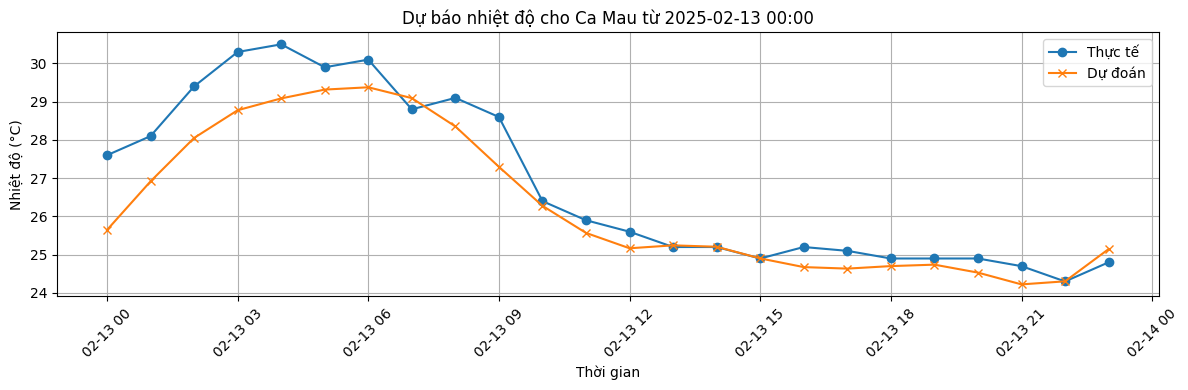

Cam Pha: MSE=0.76, MAE=0.67°C


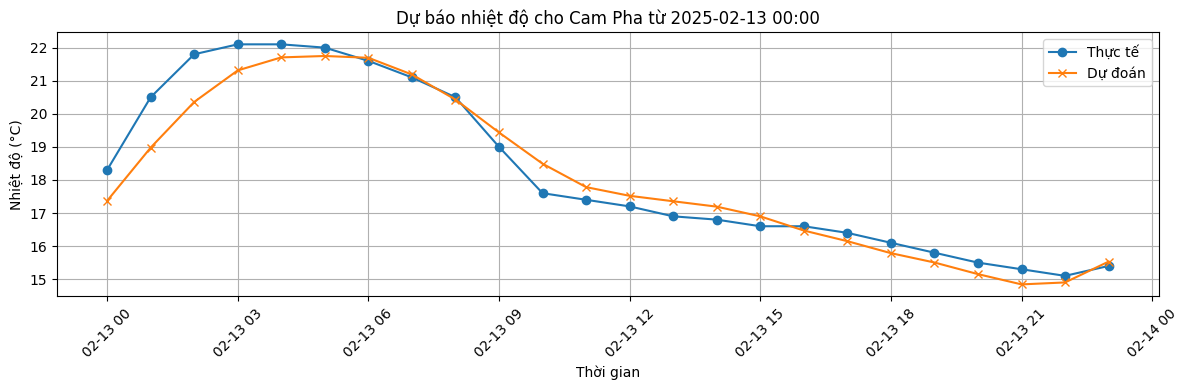

Can Tho: MSE=0.64, MAE=0.60°C


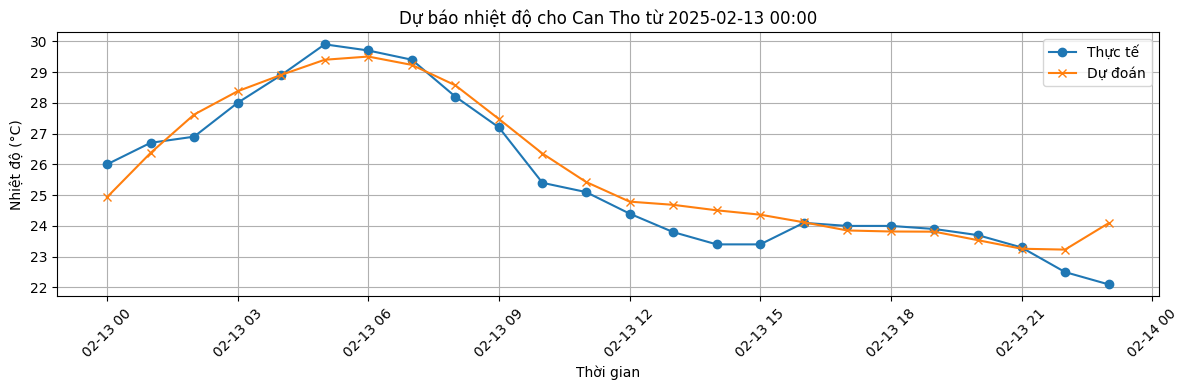

Cao Bang: MSE=1.97, MAE=1.07°C


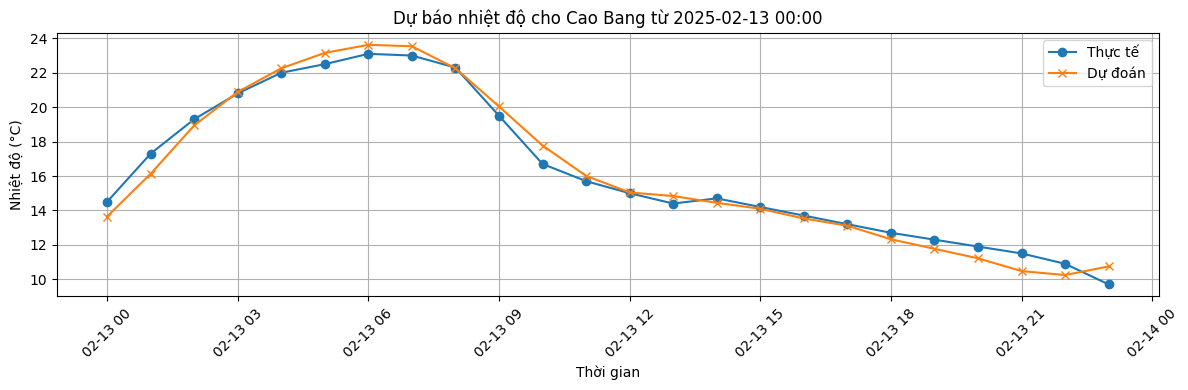

Chau Doc: MSE=0.71, MAE=0.65°C


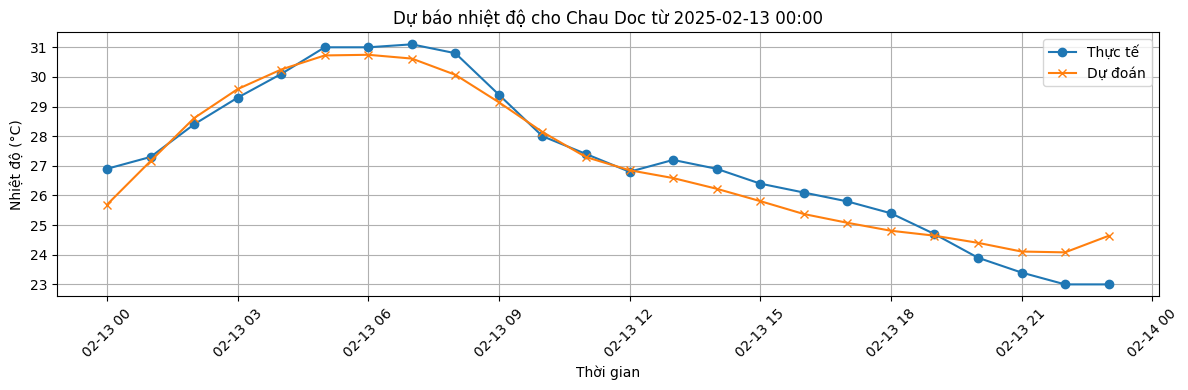

Da Lat: MSE=1.21, MAE=0.83°C


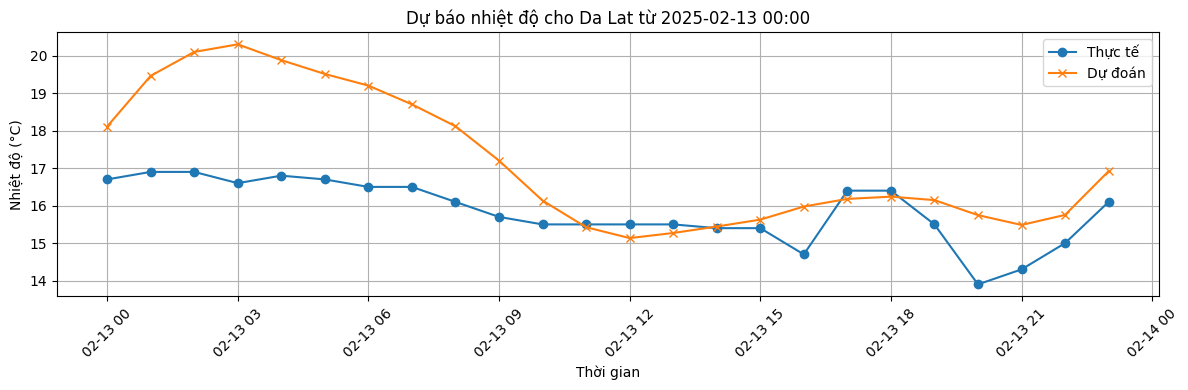

Dien Bien: MSE=1.80, MAE=1.02°C


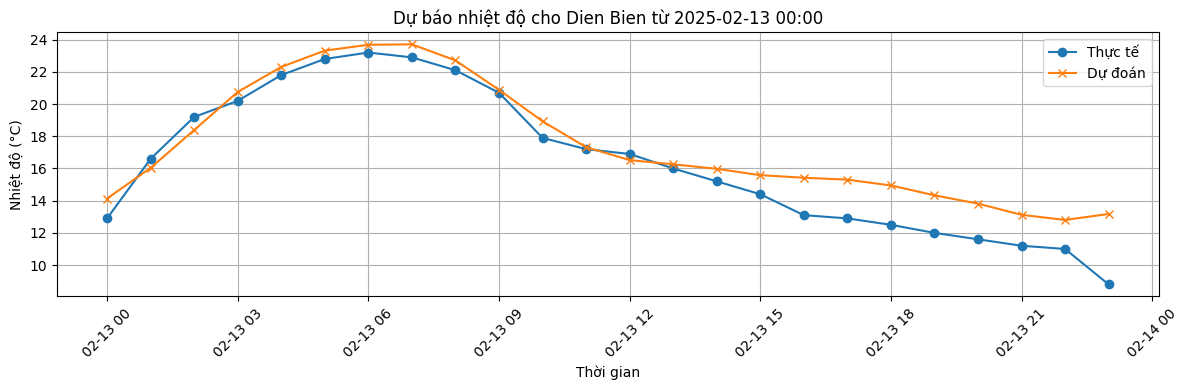

Dong Hoi: MSE=0.97, MAE=0.76°C


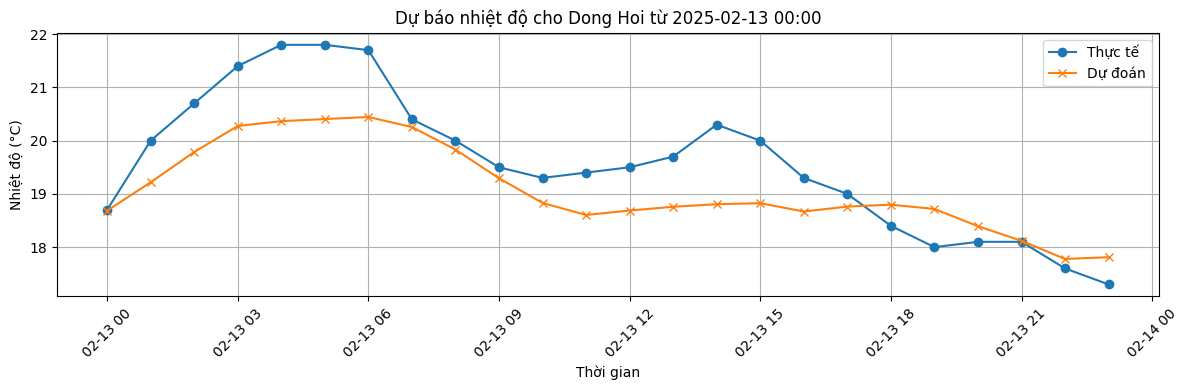

Dong Xoai: MSE=0.69, MAE=0.63°C


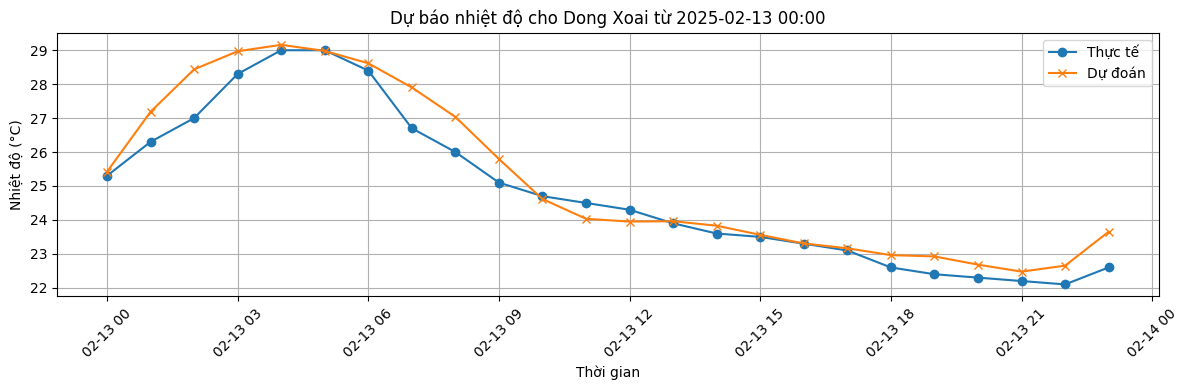

Ha Giang: MSE=1.79, MAE=1.02°C


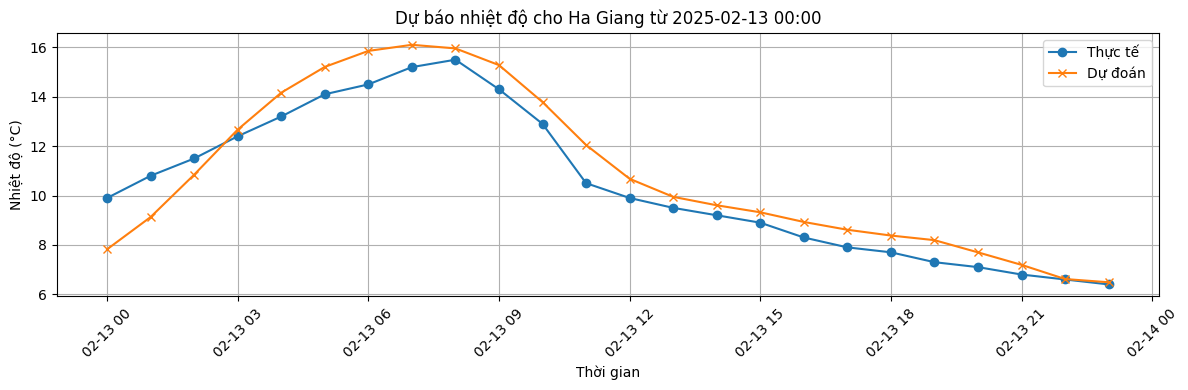

Ha Noi: MSE=1.12, MAE=0.81°C


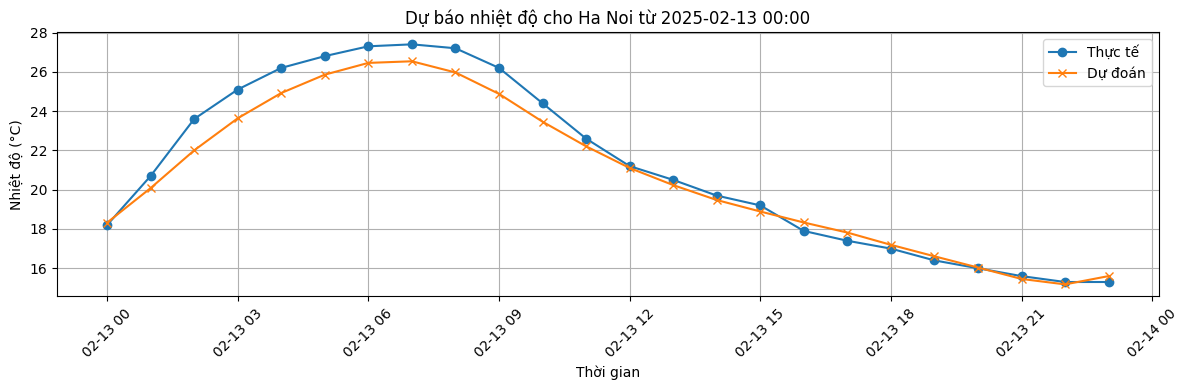

Ha Tinh: MSE=1.08, MAE=0.80°C


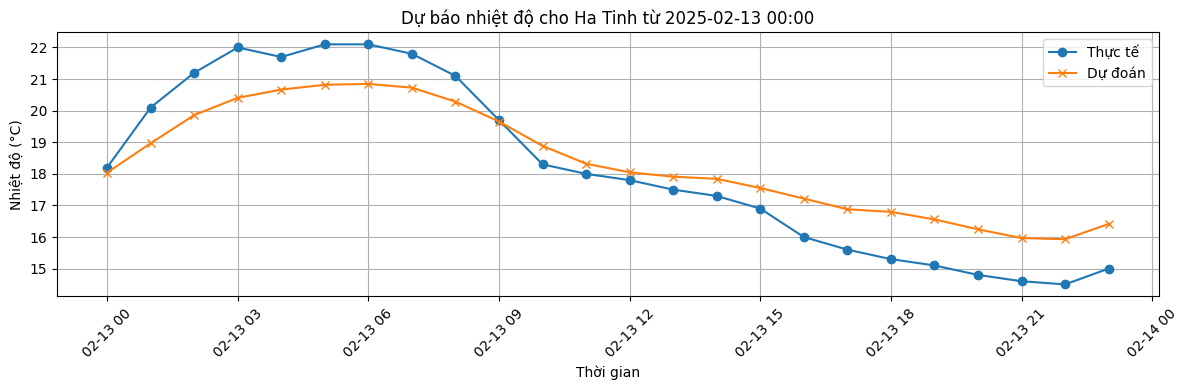

Hai Duong: MSE=0.97, MAE=0.76°C


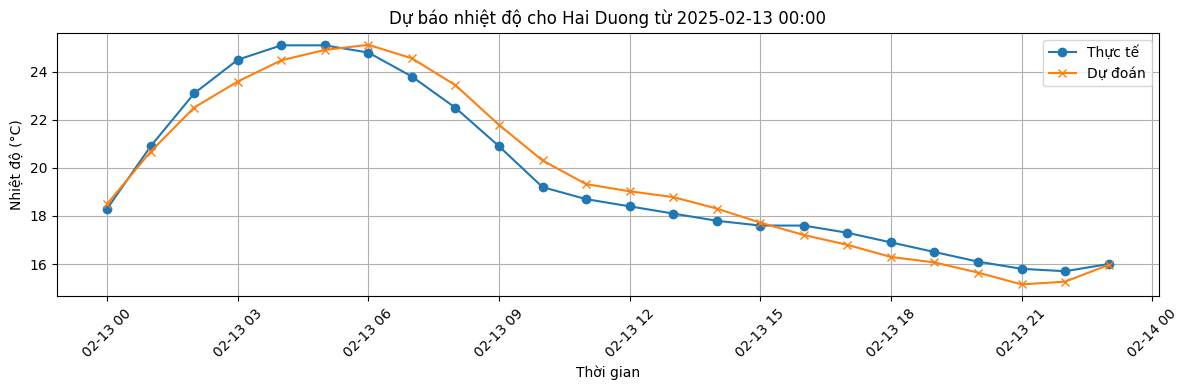

Hai Phong: MSE=0.89, MAE=0.73°C


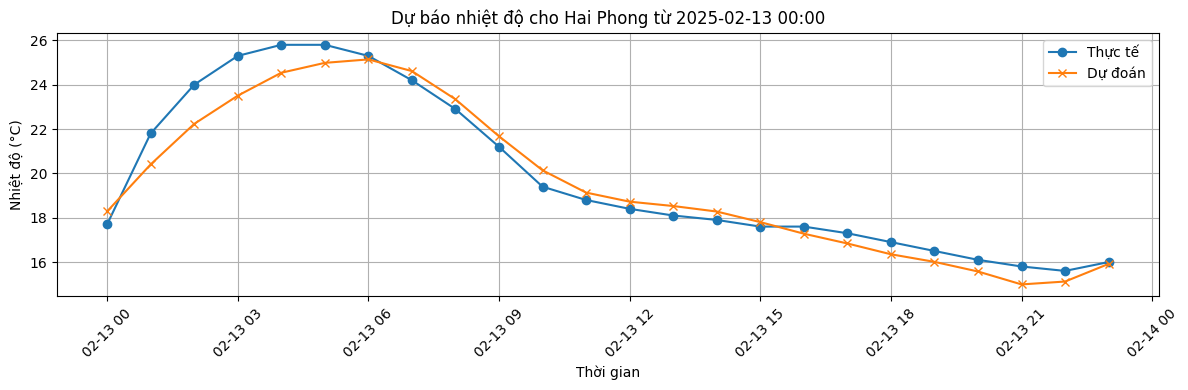

Ho Chi Minh City: MSE=0.54, MAE=0.56°C


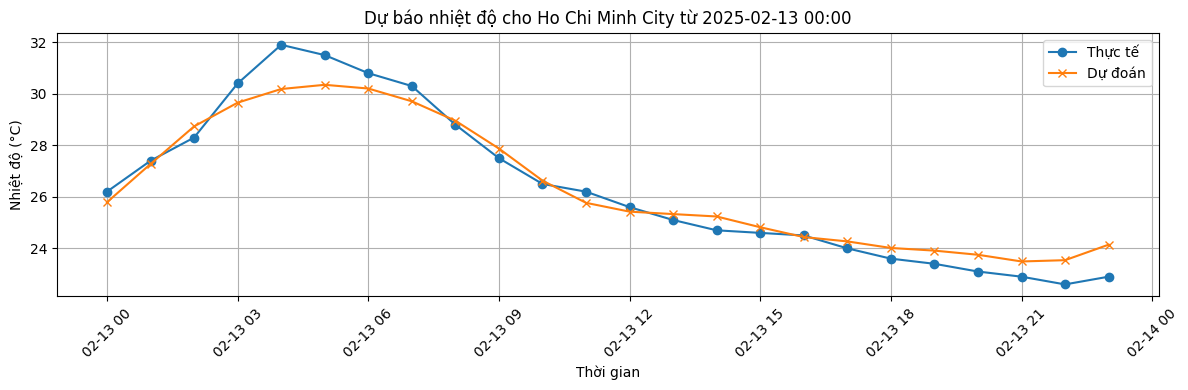

Hoa Binh: MSE=1.35, MAE=0.88°C


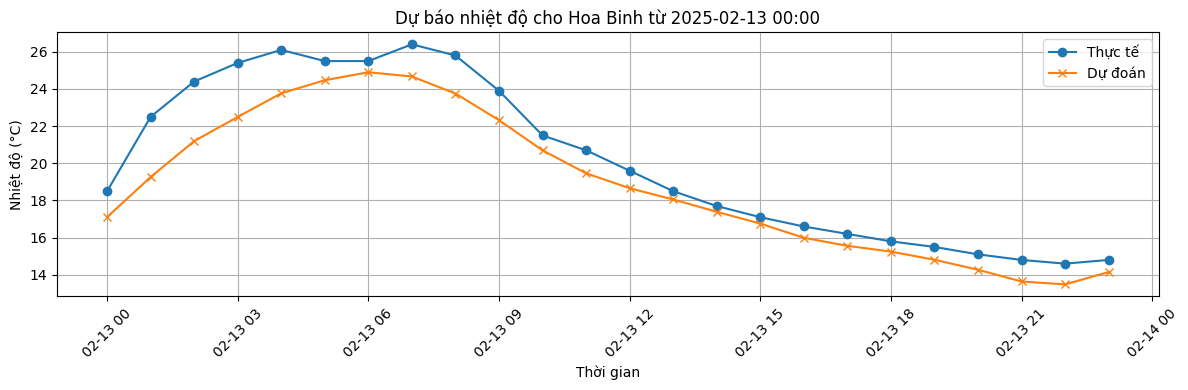

Hoi An: MSE=0.67, MAE=0.62°C


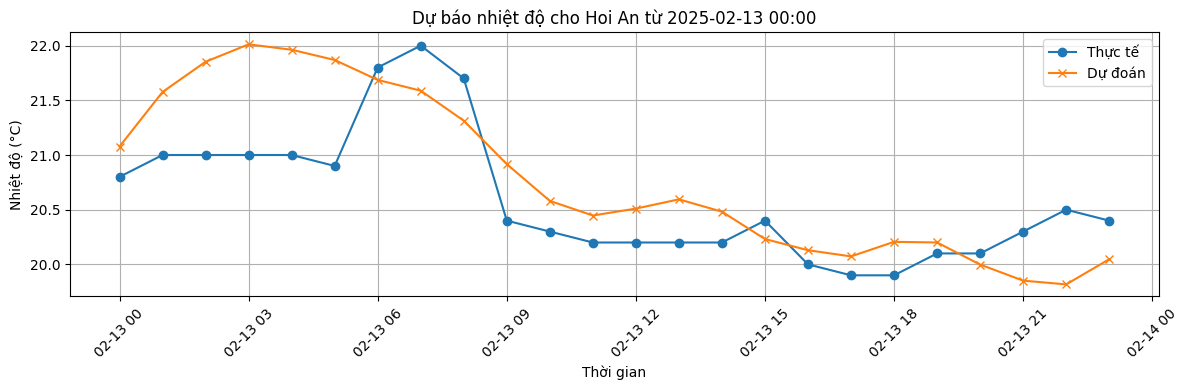

Hong-Yen: MSE=0.95, MAE=0.75°C


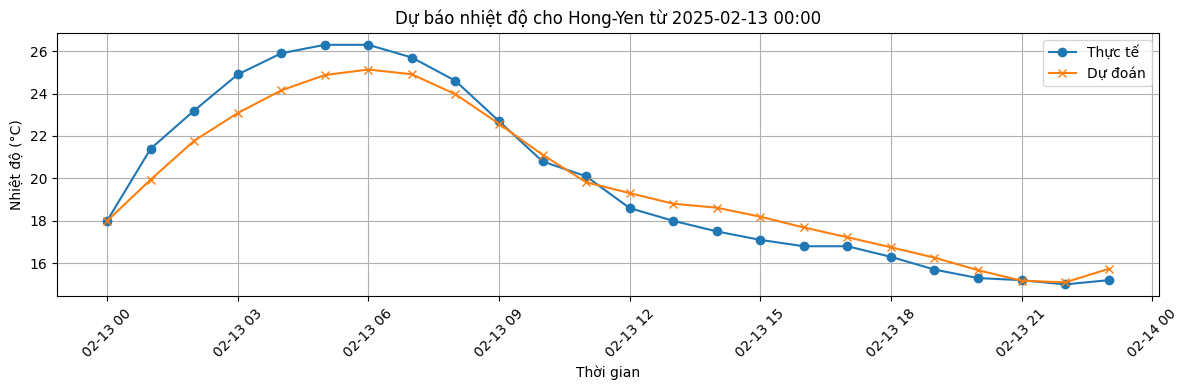

Hue: MSE=0.87, MAE=0.72°C


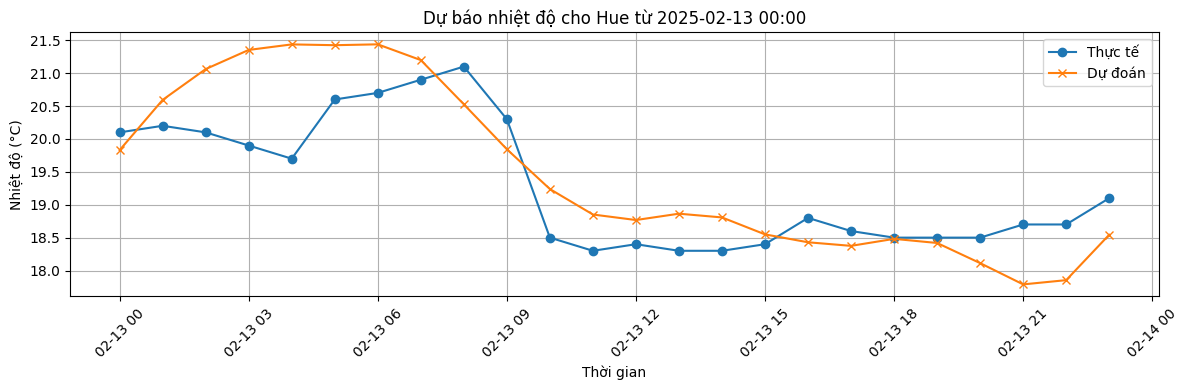

Kon Tum: MSE=1.16, MAE=0.83°C


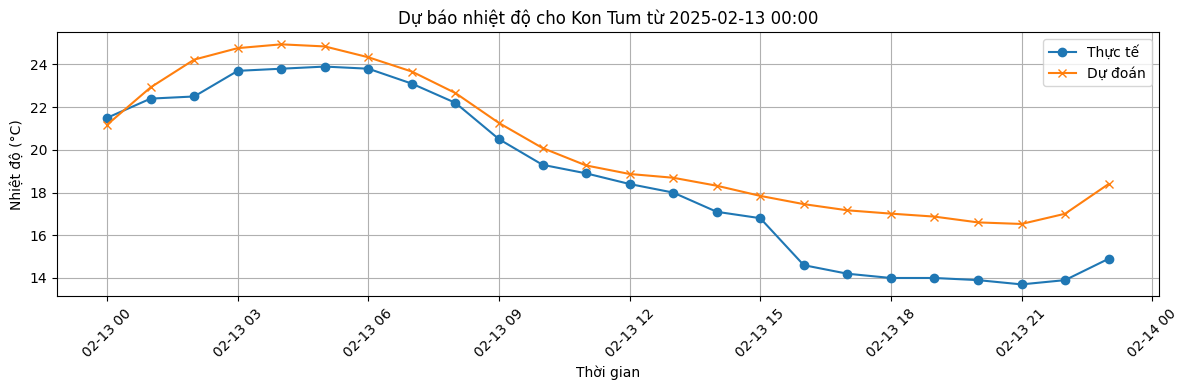

Lang Son: MSE=1.47, MAE=0.92°C


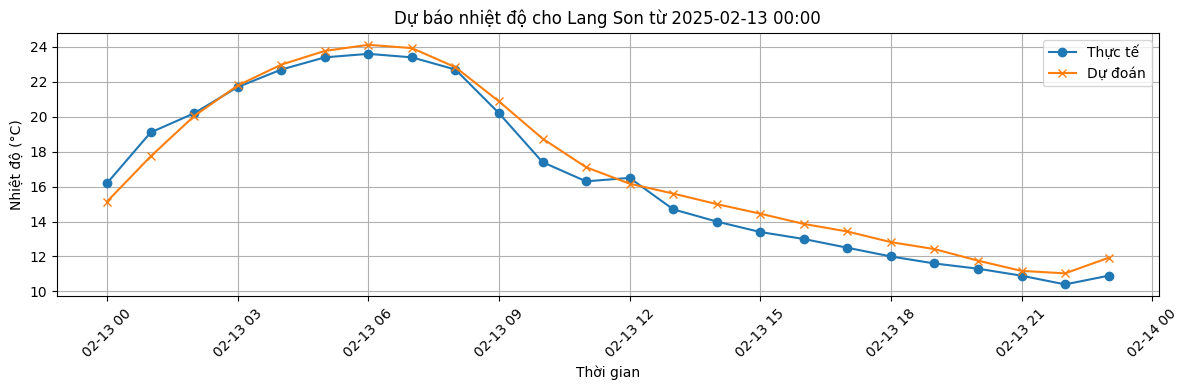

Lao Cai: MSE=1.77, MAE=1.02°C


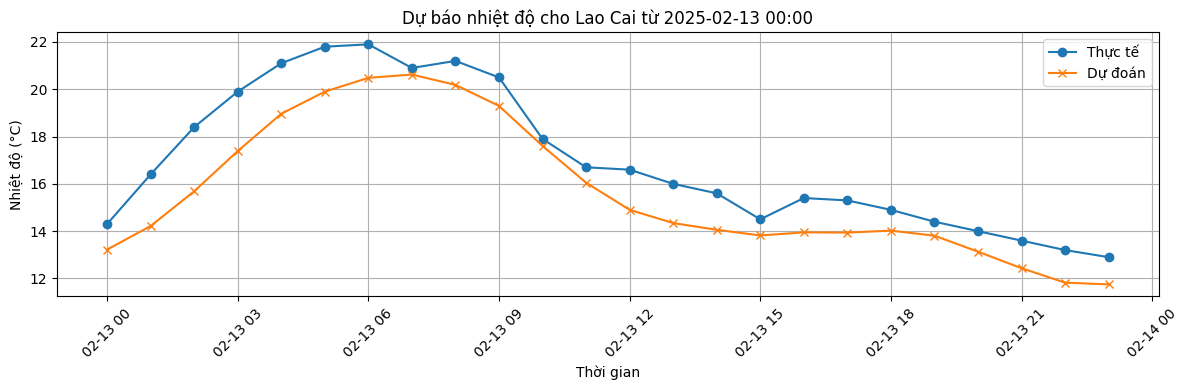

My Tho: MSE=0.61, MAE=0.59°C


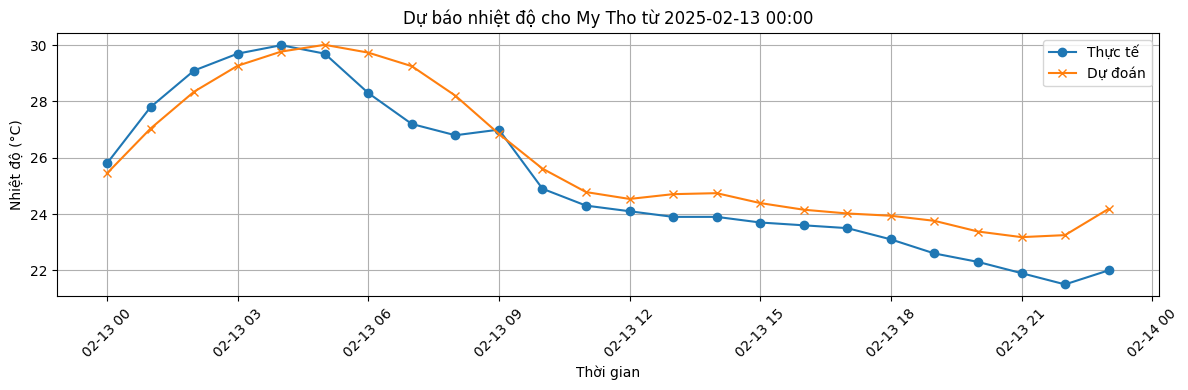

Nam Dinh: MSE=0.95, MAE=0.75°C


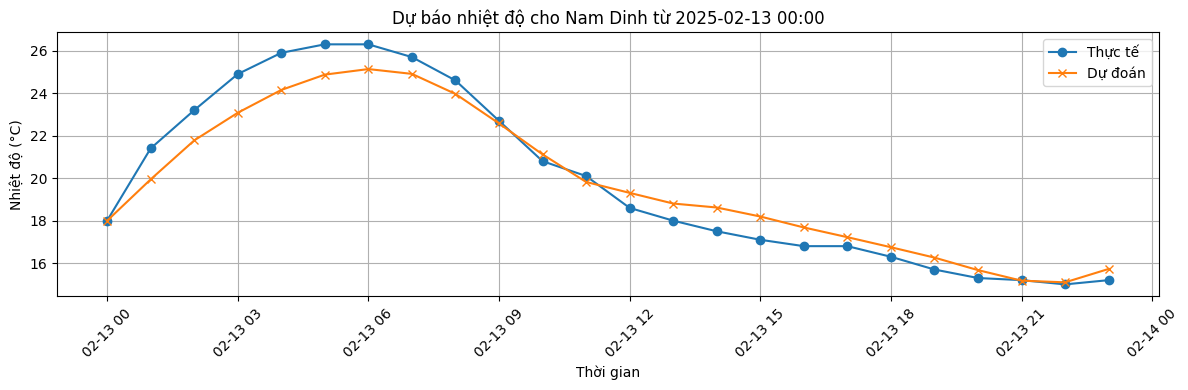

Ninh Binh: MSE=0.99, MAE=0.76°C


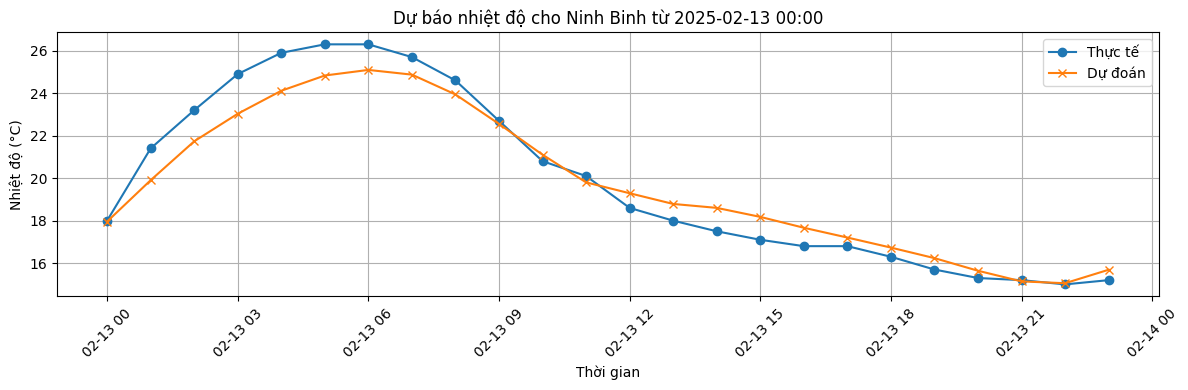

Ninh Quang: MSE=0.59, MAE=0.59°C


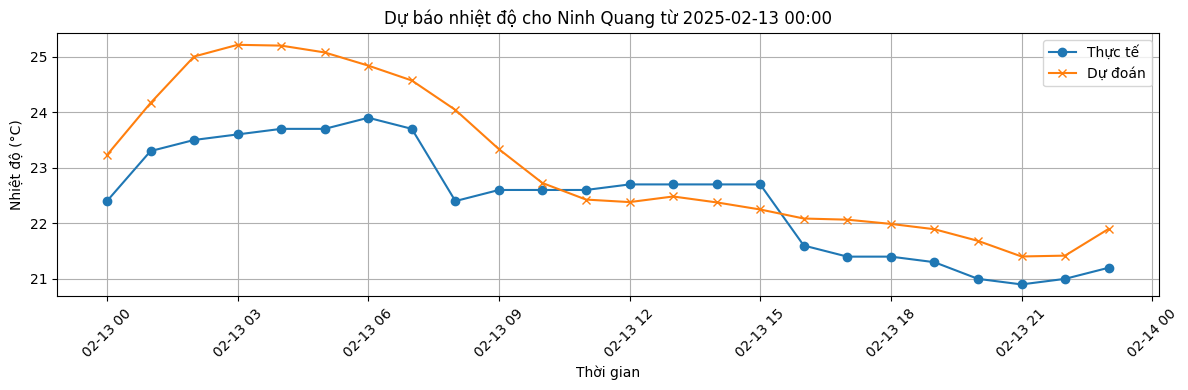

Pa Nhie: MSE=2.11, MAE=1.13°C


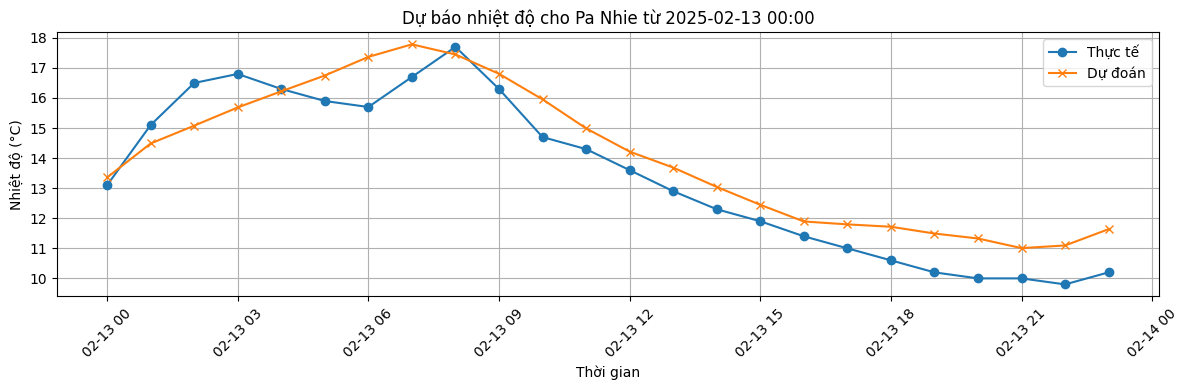

Phan Thiet: MSE=0.58, MAE=0.59°C


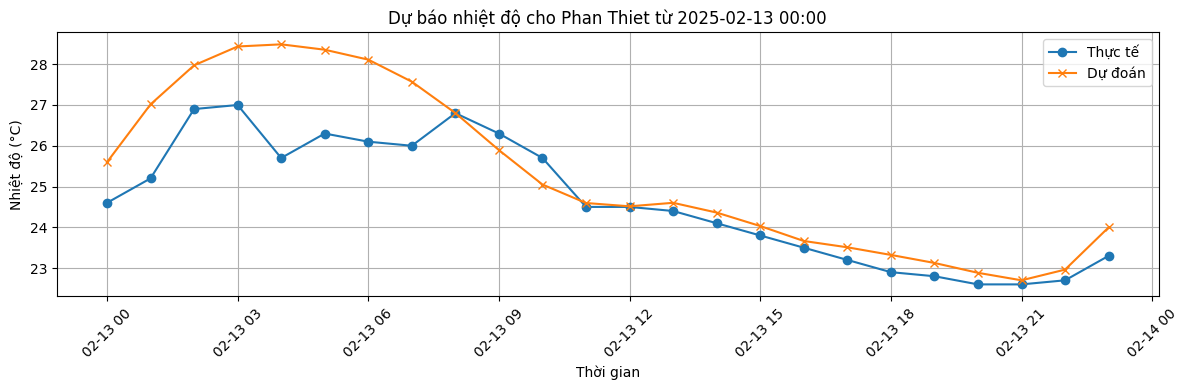

Phu Ly: MSE=1.04, MAE=0.77°C


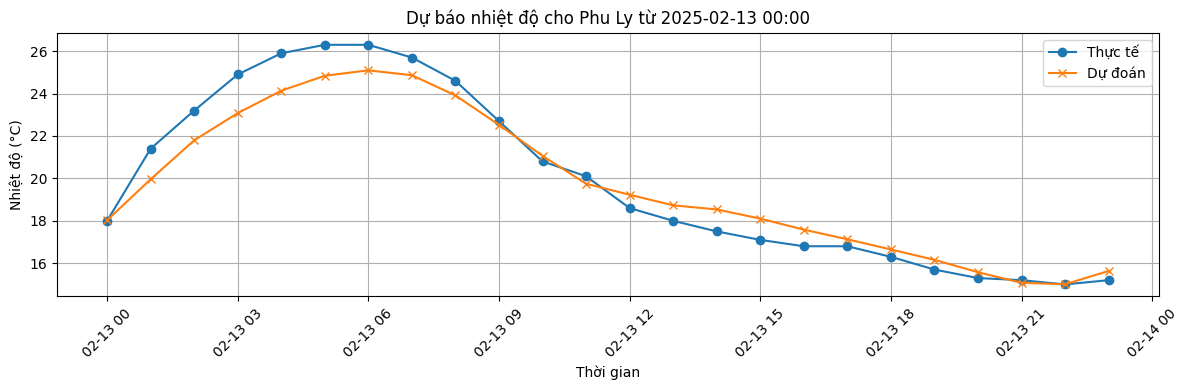

Play Cu: MSE=1.16, MAE=0.83°C


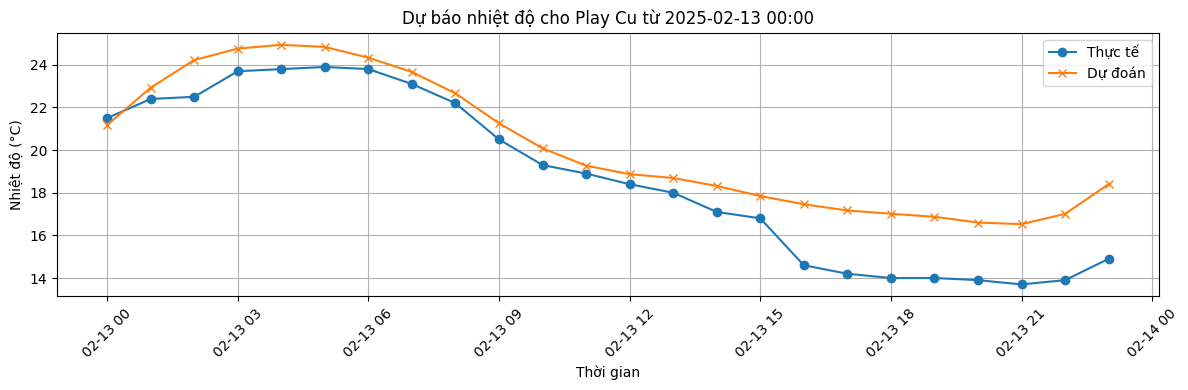

Quang Ngai: MSE=0.85, MAE=0.69°C


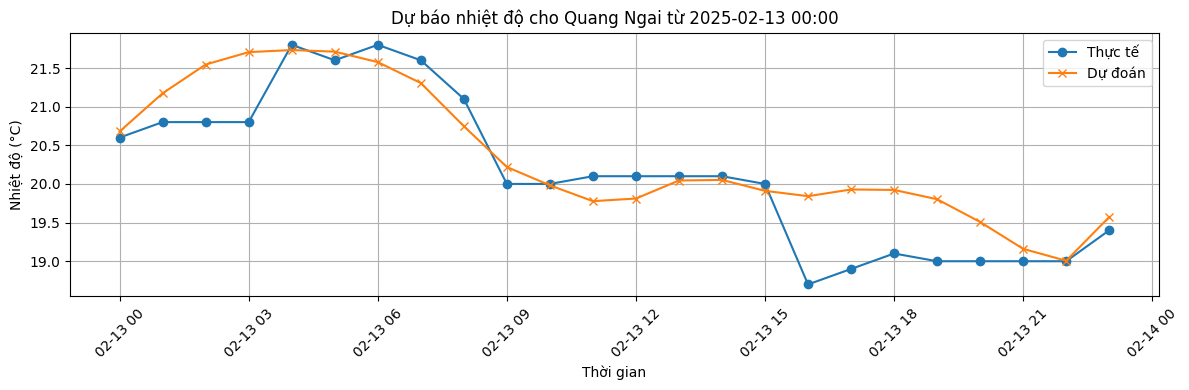

Qui Nhon: MSE=0.53, MAE=0.57°C


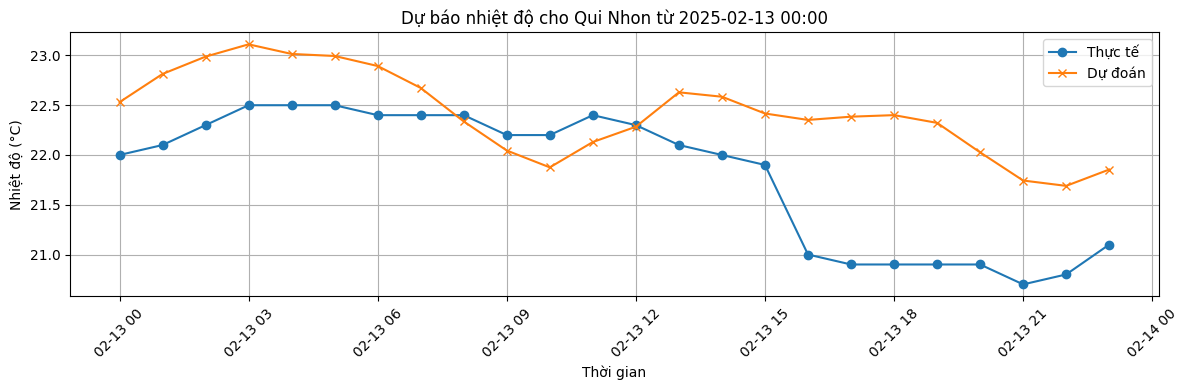

Rach Gia: MSE=0.50, MAE=0.55°C


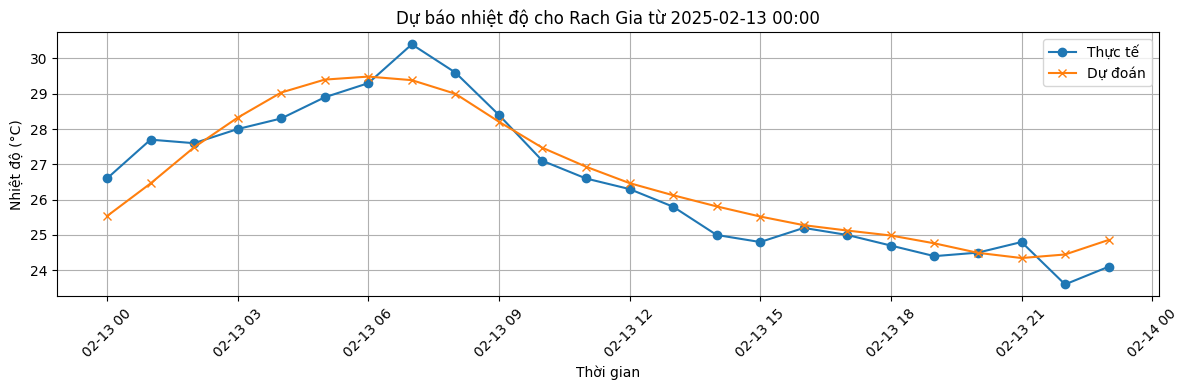

Soc Trang: MSE=0.53, MAE=0.55°C


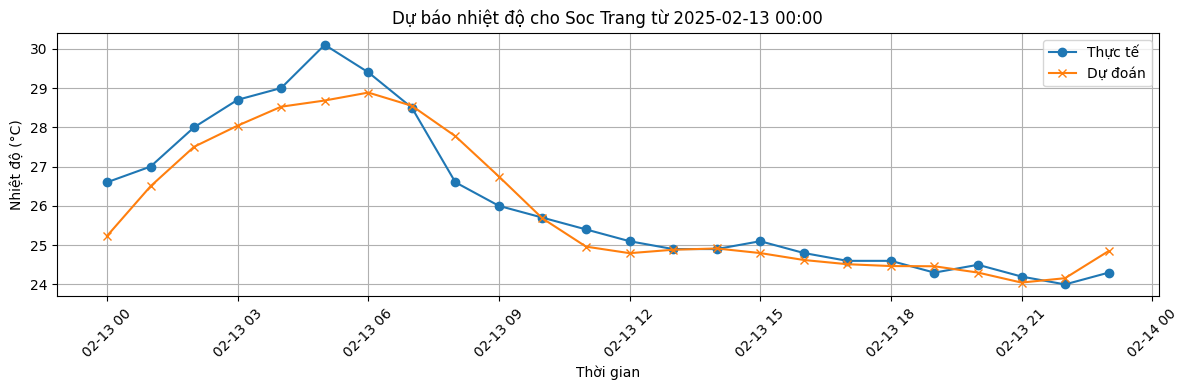

Son La: MSE=1.80, MAE=1.02°C


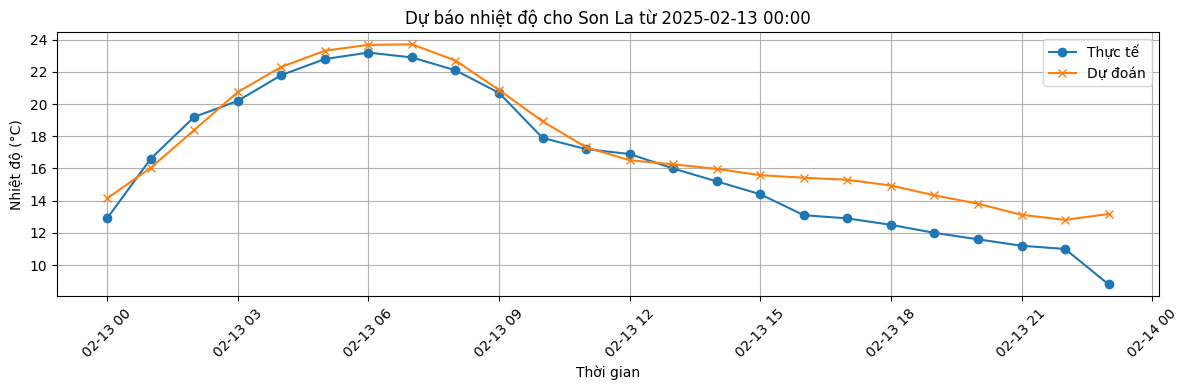

Tan An: MSE=0.55, MAE=0.56°C


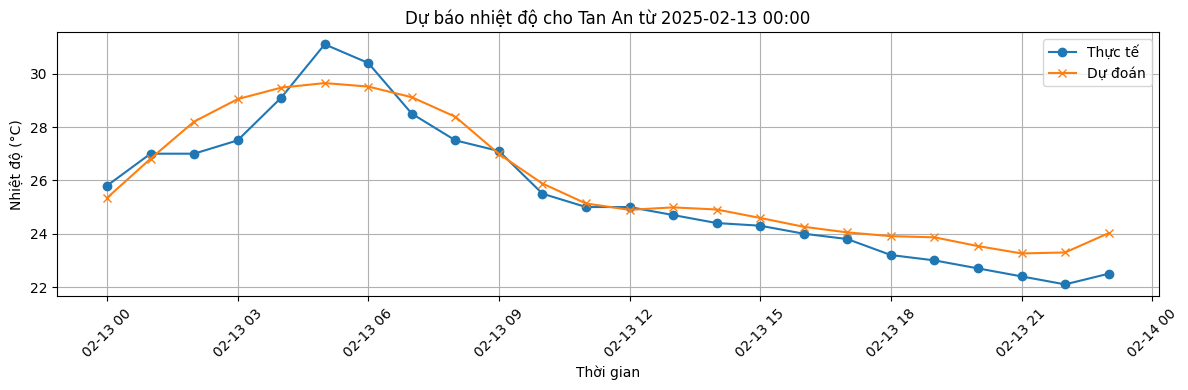

Tay Ninh: MSE=0.71, MAE=0.65°C


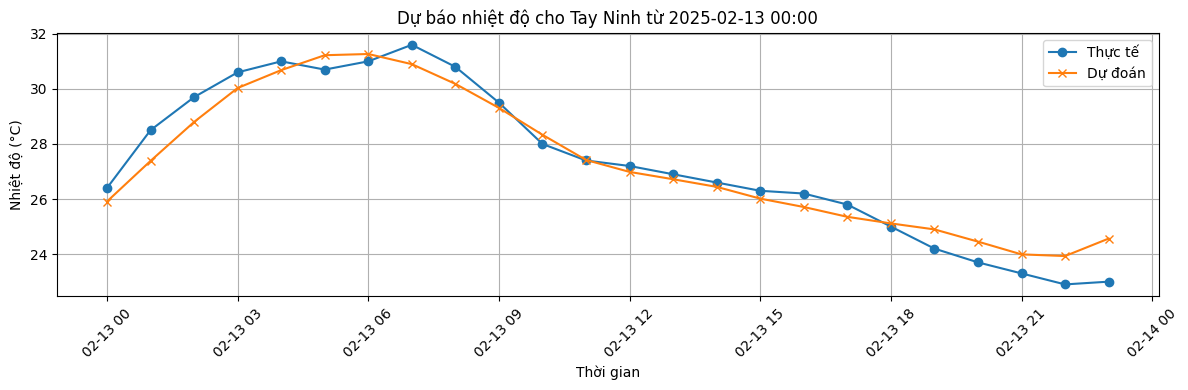

Thai Binh: MSE=0.86, MAE=0.72°C


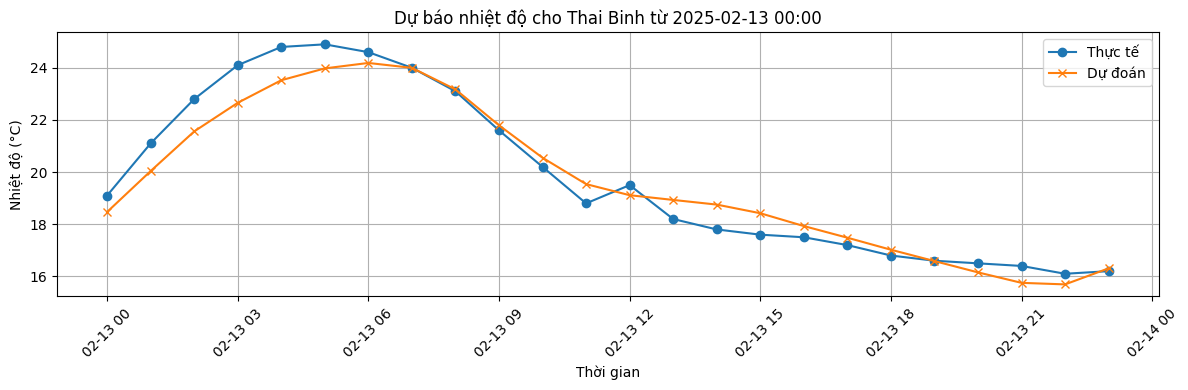

Thai Nguyen: MSE=1.11, MAE=0.82°C


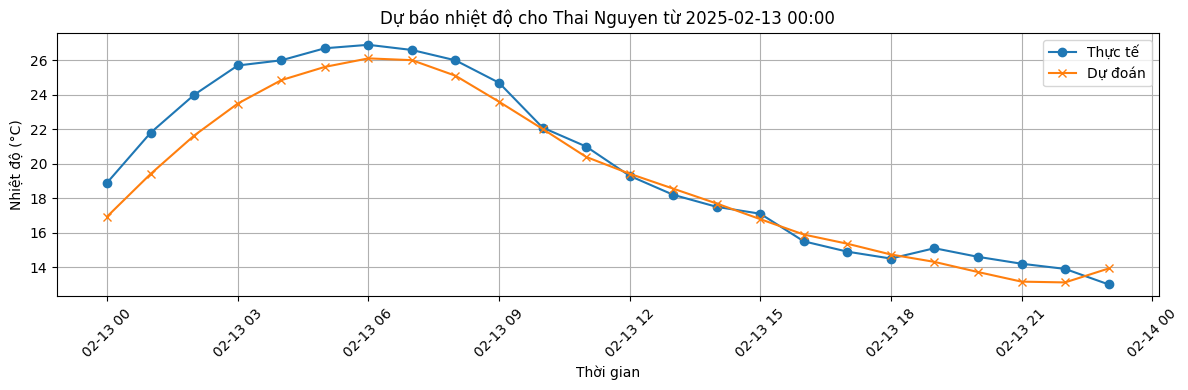

Thanh Hoa: MSE=1.09, MAE=0.79°C


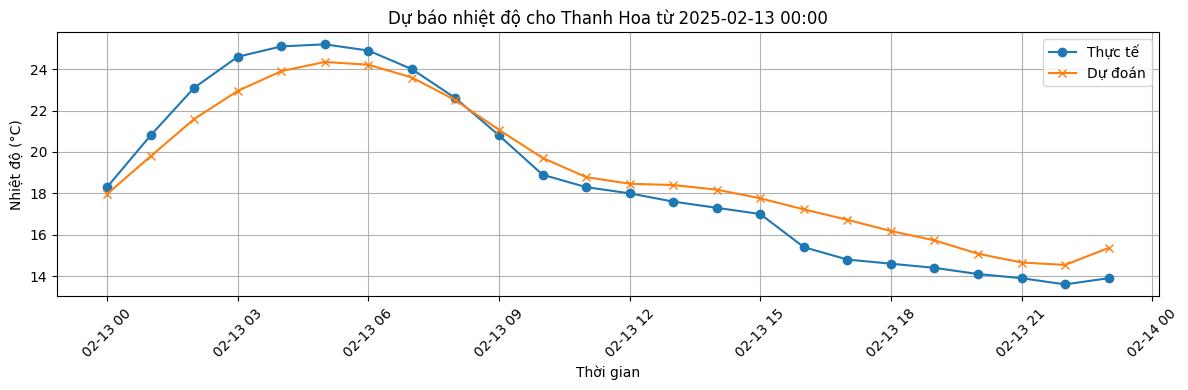

Thanh Loi: MSE=0.63, MAE=0.60°C


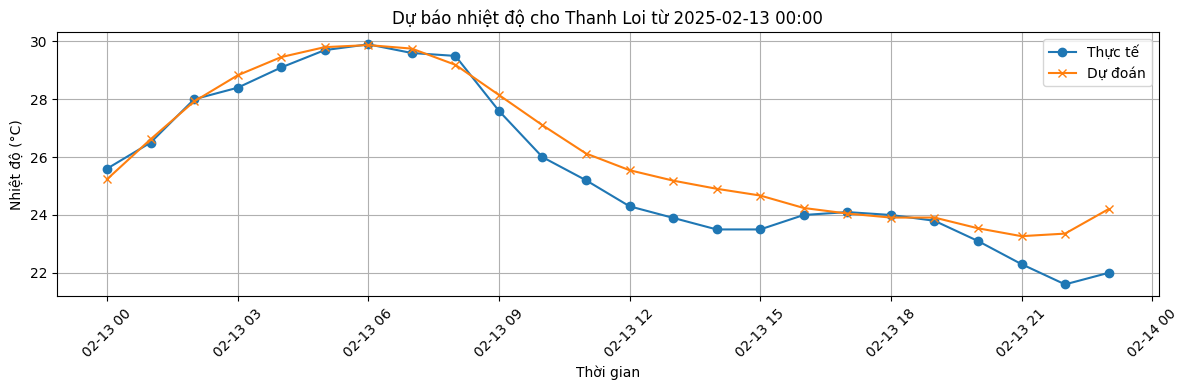

Thon Nhu Le: MSE=0.87, MAE=0.72°C


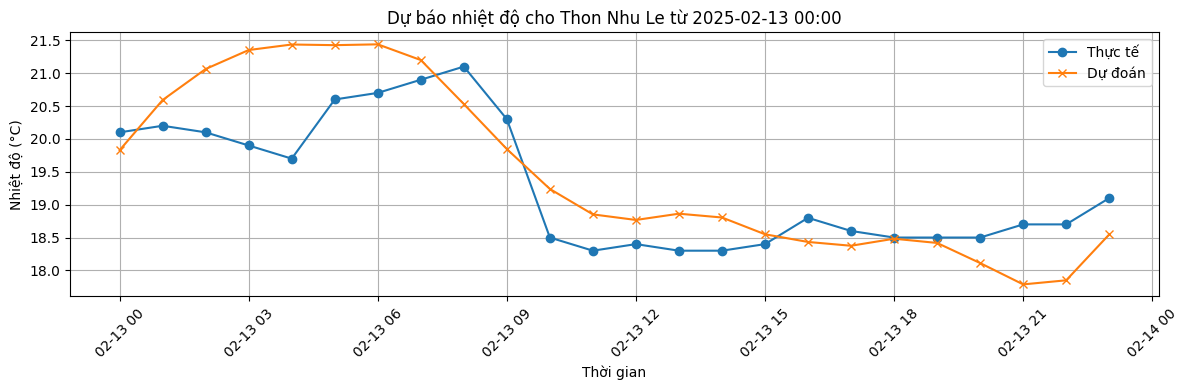

Thon Suoi La: MSE=0.43, MAE=0.50°C


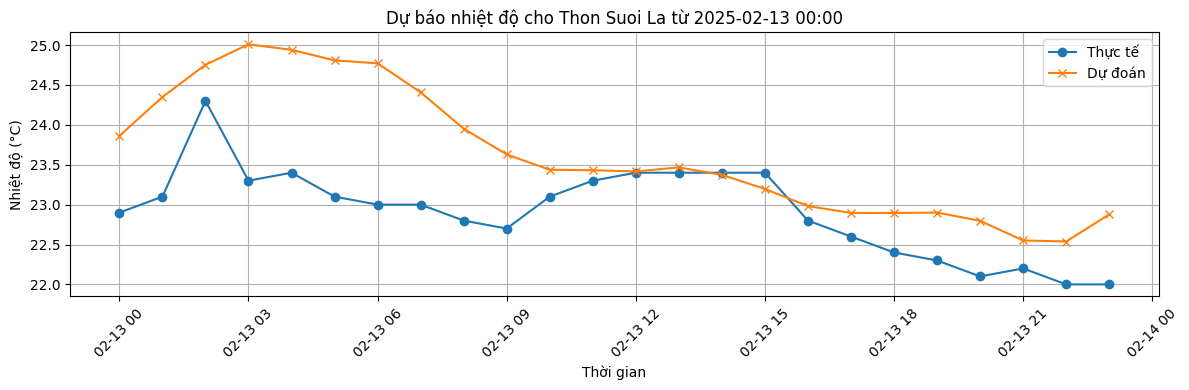

Tra Vinh: MSE=0.56, MAE=0.57°C


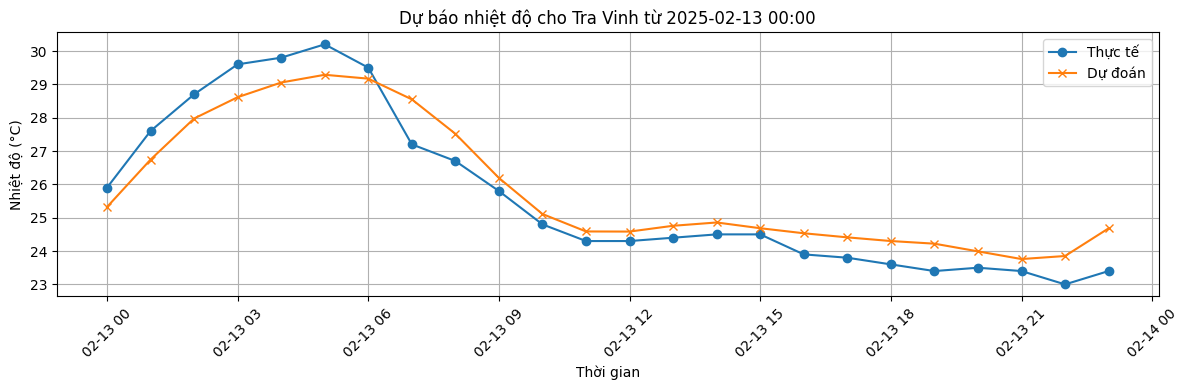

Tu Xoay: MSE=0.92, MAE=0.73°C


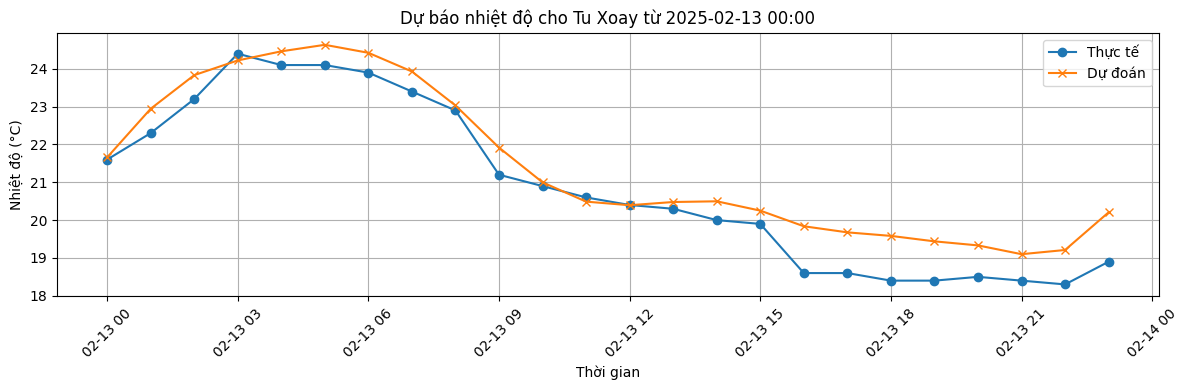

Tuyen Quang: MSE=1.03, MAE=0.78°C


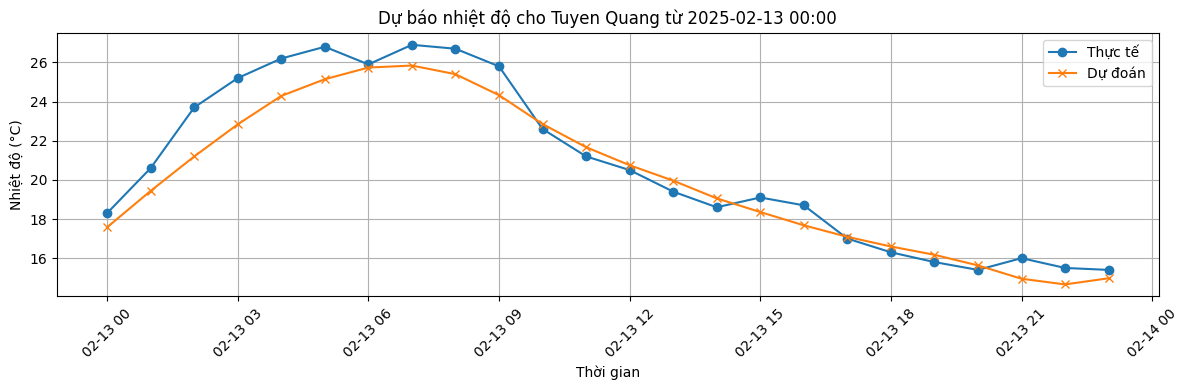

Viet Tri: MSE=1.04, MAE=0.78°C


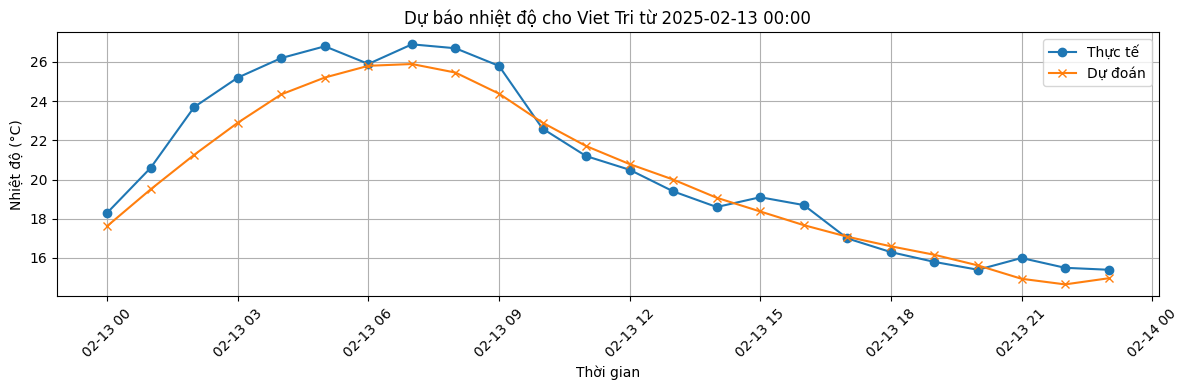

Vinh: MSE=0.99, MAE=0.76°C


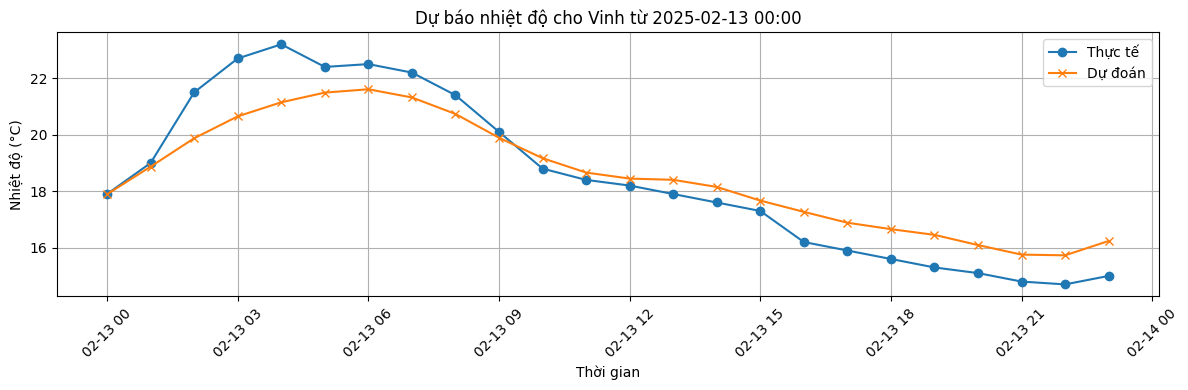

Vinh Long: MSE=0.66, MAE=0.61°C


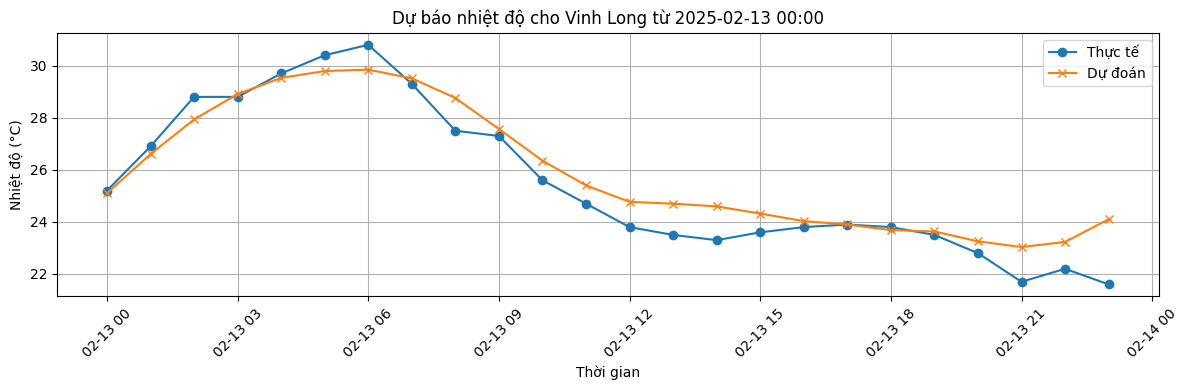

Vinh Yen: MSE=1.03, MAE=0.78°C


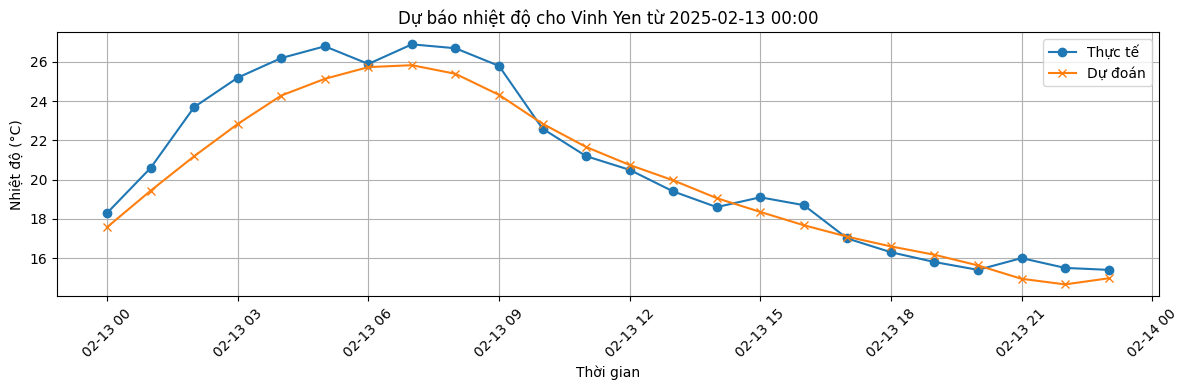

Vung Tau: MSE=0.28, MAE=0.41°C


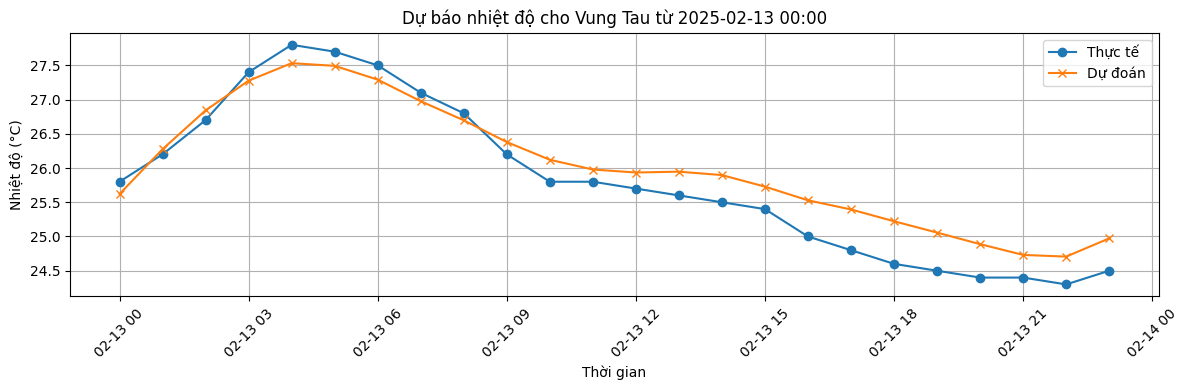

Xom Ong Ho: MSE=0.54, MAE=0.56°C


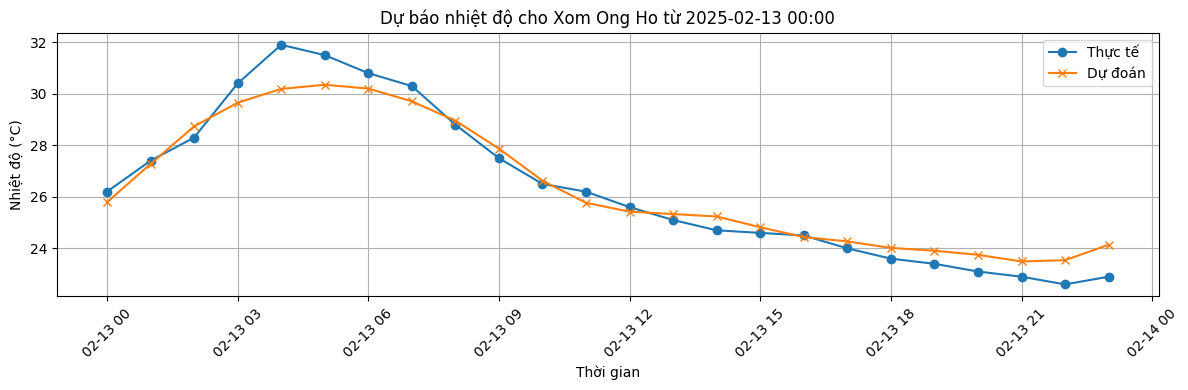

Xuan Loc Ha: MSE=0.53, MAE=0.57°C


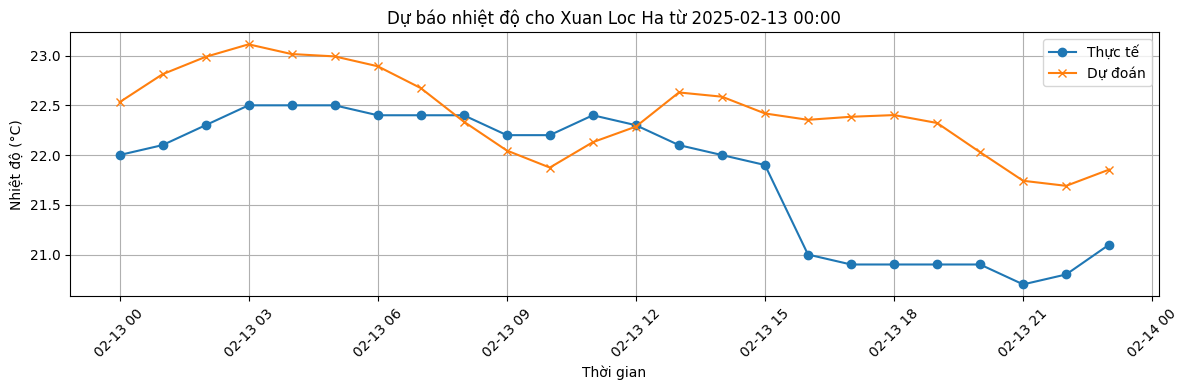

Yen Bai: MSE=1.03, MAE=0.78°C


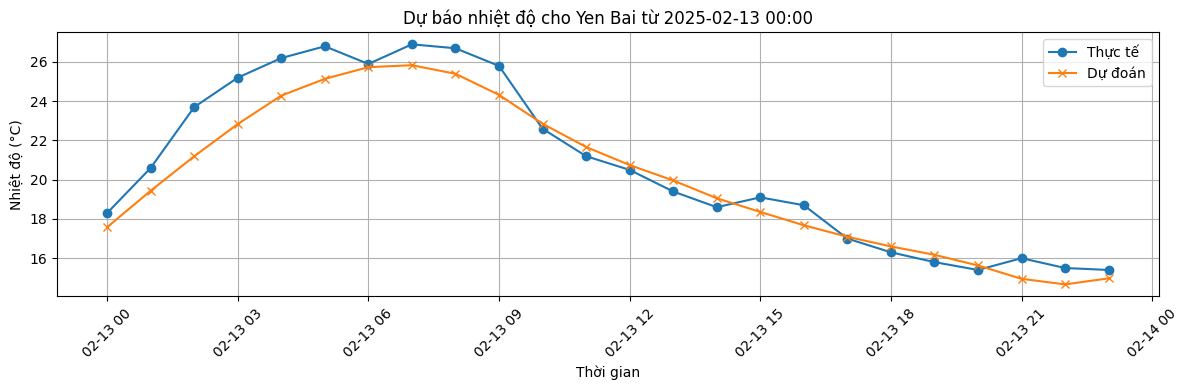

In [19]:
# [Inserted Snippet 2: Prediction and Visualization]
# Dự báo
predictions = model.predict(X_test)

# Đảo ngược chuẩn hóa cho dự báo và giá trị thực
predictions_flat = predictions.reshape(-1, predictions.shape[2])
predictions_unscaled = scaler_y.inverse_transform(predictions_flat)
predictions_unscaled = predictions_unscaled.reshape(predictions.shape)

y_test_flat = y_test.reshape(-1, y_test.shape[2])
y_test_unscaled = scaler_y.inverse_transform(y_test_flat)
y_test_unscaled = y_test_unscaled.reshape(y_test.shape)

# Lấy danh sách tỉnh
province_names = sorted(df_temp.select("location_name").distinct().rdd.flatMap(lambda x: x).collect())[:63]

# Đánh giá và trực quan hóa
for i, province in enumerate(province_names):
    actual = y_test_unscaled[:, :, i]
    pred = predictions_unscaled[:, :, i]
    
    mse = np.mean((actual - pred) ** 2)
    mae = np.mean(np.abs(actual - pred))
    print(f"{province}: MSE={mse:.2f}, MAE={mae:.2f}°C")
    
    start_time = pd.to_datetime(ts_data.index[-len(X_test):][0])
    forecast_times = pd.date_range(start=start_time, periods=24, freq='H')
    
    plt.figure(figsize=(12, 4))
    plt.plot(forecast_times, actual[0], label='Thực tế', marker='o')
    plt.plot(forecast_times, pred[0], label='Dự đoán', marker='x')
    plt.title(f'Dự báo nhiệt độ cho {province} từ {start_time.strftime("%Y-%m-%d %H:%M")}')
    plt.xlabel('Thời gian')
    plt.ylabel('Nhiệt độ (°C)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    plt.show()
    plt.close()

In [20]:
from pyspark.sql.functions import col, when, rand

# Create df_temp with simulated predicted_temp_c
df_temp = df.withColumn("predicted_temp_c", col("temp_c") + (rand() * 2 - 1) * 2)  # Add random noise (±2°C)

# Create df_rain with simulated predicted_will_it_rain
df_rain = df.withColumn("predicted_will_it_rain", when(col("chance_of_rain") >= 50, 1).otherwise(0))

In [21]:
from pyspark.sql.functions import col, abs, pow, sqrt
from pyspark.sql import functions as F

# Calculate MAE
mae = df_temp.select(F.avg(abs(col("temp_c") - col("predicted_temp_c"))).alias("mae")).collect()[0]["mae"]

# Calculate RMSE
rmse = df_temp.select(sqrt(F.avg(pow(col("temp_c") - col("predicted_temp_c"), 2))).alias("rmse")).collect()[0]["rmse"]

print(f"MAE for temperature prediction: {mae:.4f}")
print(f"RMSE for temperature prediction: {rmse:.4f}")

MAE for temperature prediction: 0.9986
RMSE for temperature prediction: 1.1534


# Dataset dự đoán nắng mưa

## Kiểm tra số lượng giá trị nắng mưa

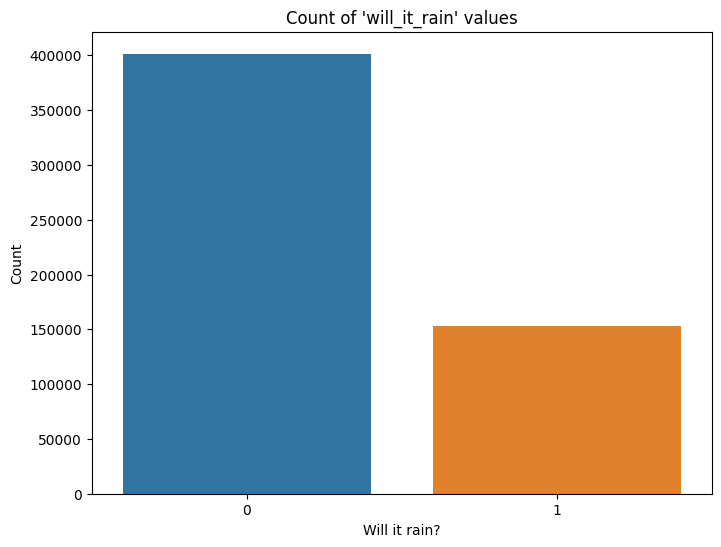

In [22]:
import matplotlib.pyplot as plt

will_it_rain_counts = df.groupBy("will_it_rain").count().toPandas()

plt.figure(figsize=(8, 6))
sns.barplot(x="will_it_rain", y="count", data=will_it_rain_counts)
plt.title("Count of 'will_it_rain' values")
plt.xlabel("Will it rain?")
plt.ylabel("Count")
plt.show()


In [23]:
df_rain = df['location_name',
 'location',
 'time',
 'temp_c',
 'is_day',
 'wind_mph',
 'wind_degree',
 'pressure_mb',
 'precip_mm',
 'humidity',
 'cloud',
 'windchill_c',
 'heatindex_c',
 'dewpoint_c',
 'vis_km',
 'uv',
 'gust_mph',
 'will_it_rain',
 'chance_of_rain',
 'condition_text',
 'wind_dir']

In [24]:
from pyspark.sql import functions as F

# Create pivot table for chance_of_rain by location
pivot_rain_df = df_rain.groupBy("time").pivot("location_name").agg(F.first("chance_of_rain"))

# Add meta features (ensure correct column names)
meta_rain_features = df_rain.drop("location_name").groupBy("time").agg(
    F.first("temp_c").alias("temp_c"),
    F.first("is_day").alias("is_day"),
    F.first("wind_mph").alias("wind_mph"),
    F.first("wind_degree").alias("wind_degree"),
    F.first("pressure_mb").alias("pressure_mb"),  # Correct column name
    F.first("cloud").alias("cloud"),
    F.first("windchill_c").alias("windchill_c"),
    F.first("heatindex_c").alias("heatindex_c"),
    F.first("dewpoint_c").alias("dewpoint_c"),
    F.first("will_it_rain").alias("will_it_rain"),
    F.first("precip_mm").alias("precip_mm"),
    F.first("humidity").alias("humidity"),
    F.first("vis_km").alias("vis_km"),
    F.first("gust_mph").alias("gust_mph"),
    F.first("uv").alias("uv"),
    F.first("condition_text").alias("condition"),
    F.first("wind_dir").alias("wind_dir")  # Corrected from wind_direct to wind_dir
)

# Join the pivoted rain data with meta features
final_rain_df = pivot_rain_df.join(meta_rain_features, on="time", how="inner")

In [25]:
# Define columns for Imputer (rain columns + meta features)
rain_columns = [col for col in final_rain_df.columns if col not in [
    'time', 'is_day', 'wind_mph', 'wind_degree', 'pressure_mb', 'cloud', 
    'windchill_c', 'heatindex_c', 'dewpoint_c', 'will_it_rain', 'precip_mm', 
    'humidity', 'vis_km', 'gust_mph', 'uv', 'condition', 'wind_dir'
]]

# Apply Imputer to handle NaN values
from pyspark.ml.feature import Imputer

imputer = Imputer(
    inputCols=rain_columns + [
        "wind_mph", "wind_degree", "pressure_mb", "cloud", "windchill_c", 
        "heatindex_c", "dewpoint_c", "will_it_rain", "precip_mm", "humidity", 
        "vis_km", "gust_mph", "uv"
    ],
    outputCols=rain_columns + [
        "wind_mph", "wind_degree", "pressure_mb", "cloud", "windchill_c", 
        "heatindex_c", "dewpoint_c", "will_it_rain", "precip_mm", "humidity", 
        "vis_km", "gust_mph", "uv"
    ]
).setStrategy("mean")

# Fit and transform the DataFrame
final_rain_df_imputed = imputer.fit(final_rain_df).transform(final_rain_df)

In [26]:
# Chuyển đổi sang Pandas DataFrame với datetime index
pandas_rain_df = final_rain_df_imputed.orderBy("time").toPandas()
pandas_rain_df['time'] = pd.to_datetime(pandas_rain_df['time'])
pandas_rain_df.set_index('time', inplace=True)
ts_rain_data = pandas_rain_df.drop(columns=['condition', 'wind_dir'])  # Loại bỏ cột không phải số

In [27]:
# [Inserted Snippet 1: Time Window Function]
def create_time_windows_optimized(data, window_size, horizon, batch_size=1000):
    total_samples = len(data) - window_size - horizon
    X_batches = []
    y_batches = []
    
    for start_idx in range(0, total_samples, batch_size):
        end_idx = min(start_idx + batch_size, total_samples)
        X_batch = np.zeros((end_idx - start_idx, window_size, data.shape[1]))
        y_batch = np.zeros((end_idx - start_idx, horizon, 63))
        
        for i in range(start_idx, end_idx):
            X_batch[i - start_idx] = data.iloc[i:i + window_size].values
            y_batch[i - start_idx] = data.iloc[i + window_size:i + window_size + horizon, :63].values
        
        X_batches.append(X_batch)
        y_batches.append(y_batch)
    
    return np.concatenate(X_batches), np.concatenate(y_batches)

# Tạo dữ liệu
window_size = 24
horizon = 24
X, y = create_time_windows_optimized(ts_rain_data, window_size, horizon, batch_size=500)

# Chuẩn hóa dữ liệu
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Reshape X và y để chuẩn hóa
X_flat = X.reshape(-1, X.shape[2])
X_scaled = scaler_X.fit_transform(X_flat).reshape(X.shape)

y_flat = y.reshape(-1, y.shape[2])
y_scaled = scaler_y.fit_transform(y_flat).reshape(y.shape)

In [28]:
# [Inserted Snippet 2: Train-Test Split]
X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Cập nhật mô hình CNN cho dự báo đa bước
n_features = X.shape[2]
model = Sequential([
    Input(shape=(window_size, n_features)),
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(horizon * 63)  # Đầu ra: horizon * 63 tỉnh
])

# Reshape đầu ra trong mô hình
model.add(tf.keras.layers.Reshape((horizon, 63)))

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)

X_train shape: (6132, 24, 78)
y_train shape: (6132, 24, 63)
Epoch 1/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.8660 - val_loss: 0.7151
Epoch 2/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6713 - val_loss: 0.6698
Epoch 3/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.6299 - val_loss: 0.6443
Epoch 4/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6000 - val_loss: 0.6277
Epoch 5/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.5784 - val_loss: 0.6187
Epoch 6/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.5695 - val_loss: 0.6078
Epoch 7/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.5598 - val_loss: 0.6047
Epoch 8/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.5458 - val_loss: 0.5928
Epoch 9/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.5358 - val_loss: 0.5876
Epoch 10/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.5263 - val_loss: 0.5833
Epoch 11/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.5278 - val_loss:

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/tmp/ipykernel_35/3347698004.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_times = pd.date_range(start=start_time, periods=24, freq='H')


Ap Tan Qui Kinh: MSE=1095.81, MAE=24.00%


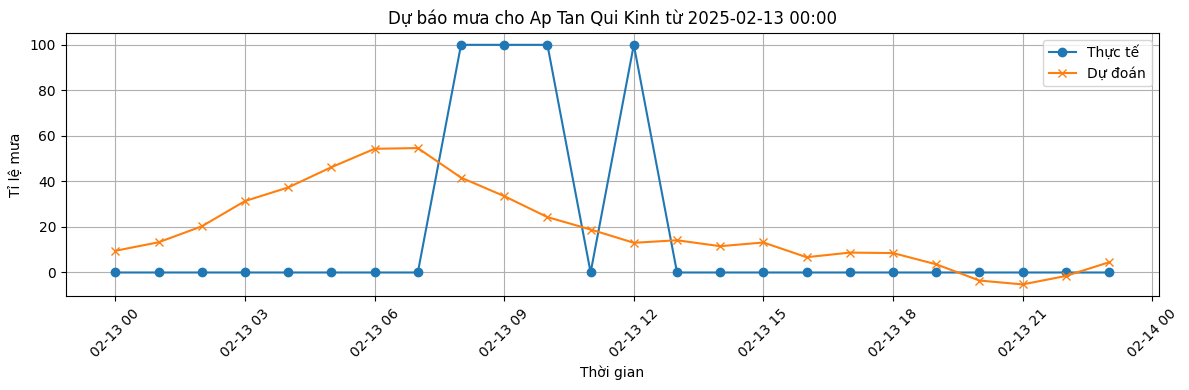

Atba Village: MSE=1175.13, MAE=26.38%


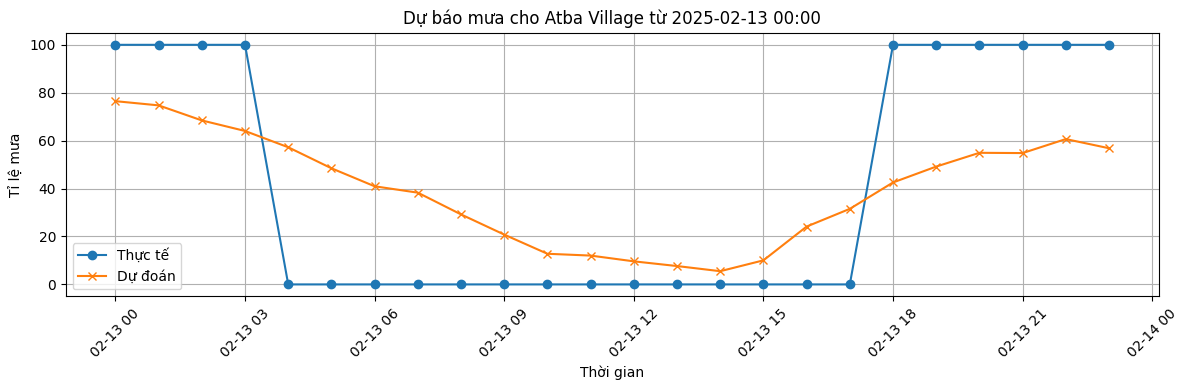

Bac Can: MSE=1173.41, MAE=25.81%


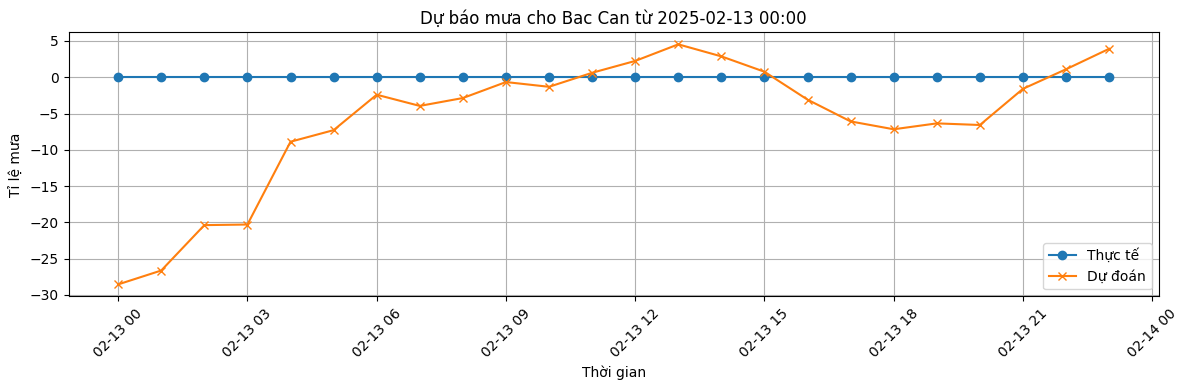

Bac Giang: MSE=971.14, MAE=21.84%


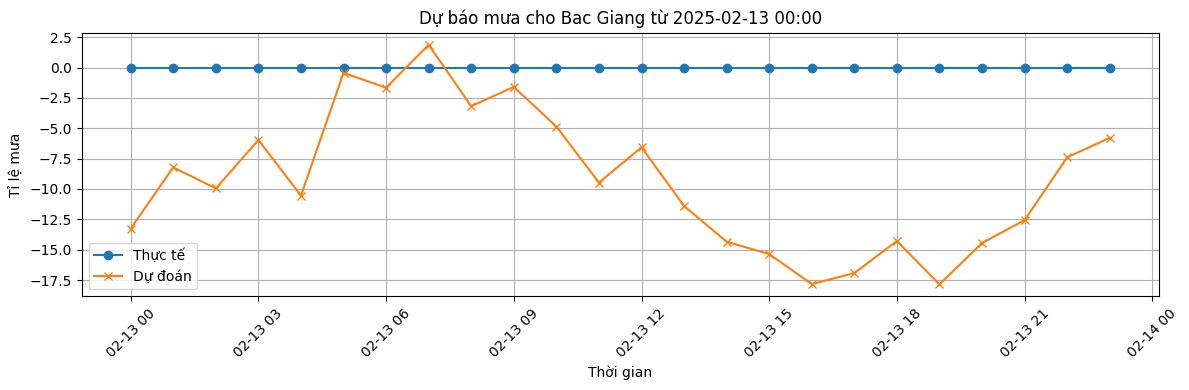

Bac Lieu: MSE=1121.61, MAE=24.51%


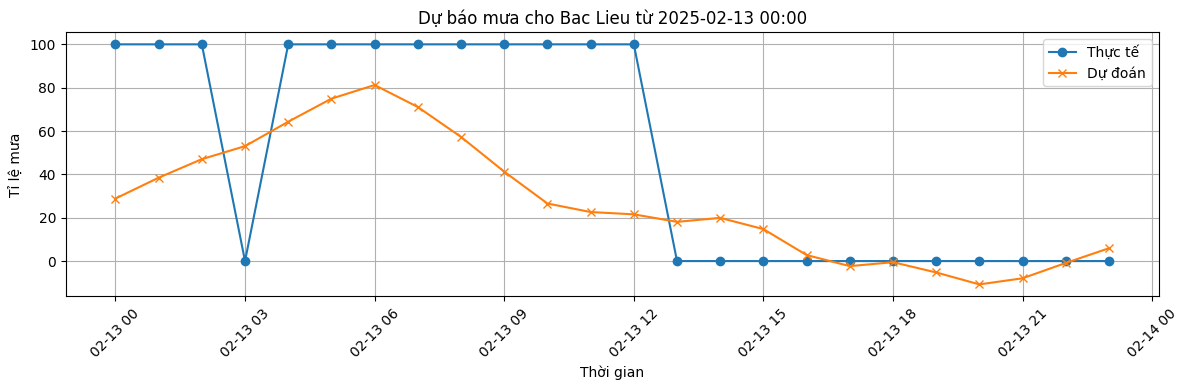

Bac Ninh: MSE=971.16, MAE=21.85%


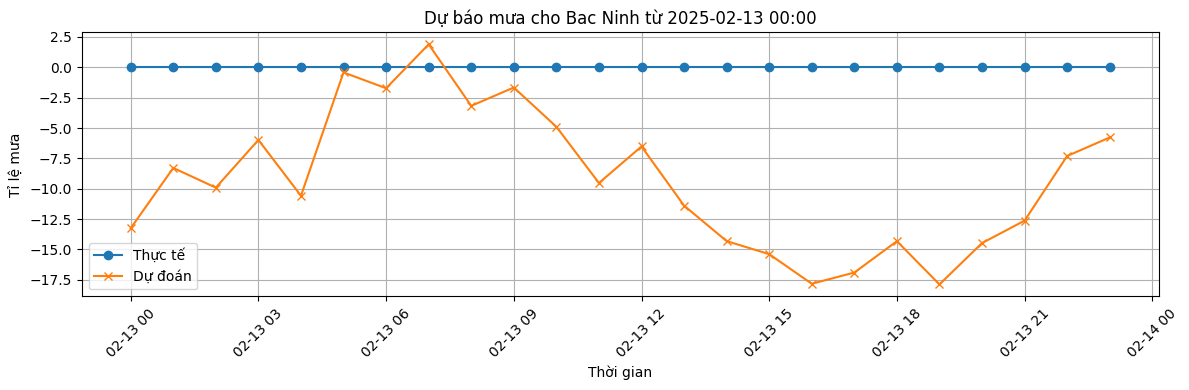

Ben Tre: MSE=1081.81, MAE=23.81%


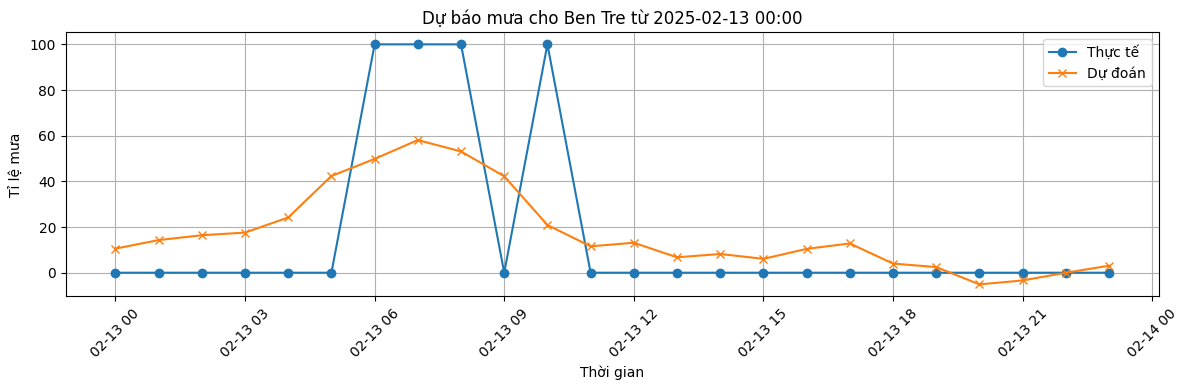

Bien Hoa: MSE=1075.30, MAE=23.61%


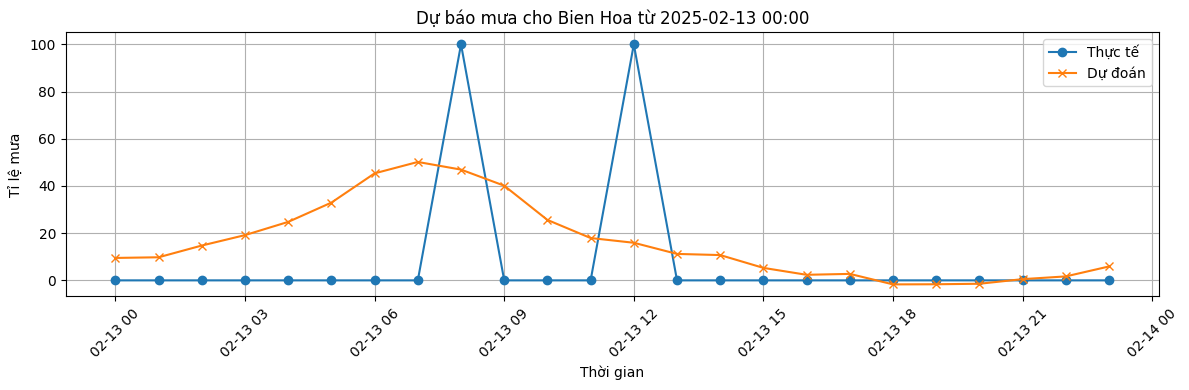

Buon Me Thuot: MSE=1055.39, MAE=22.92%


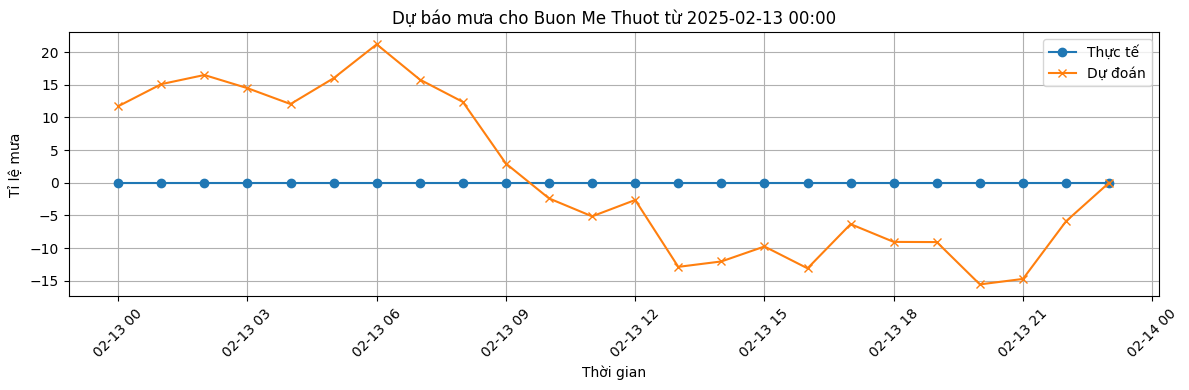

Ca Mau: MSE=1233.48, MAE=26.33%


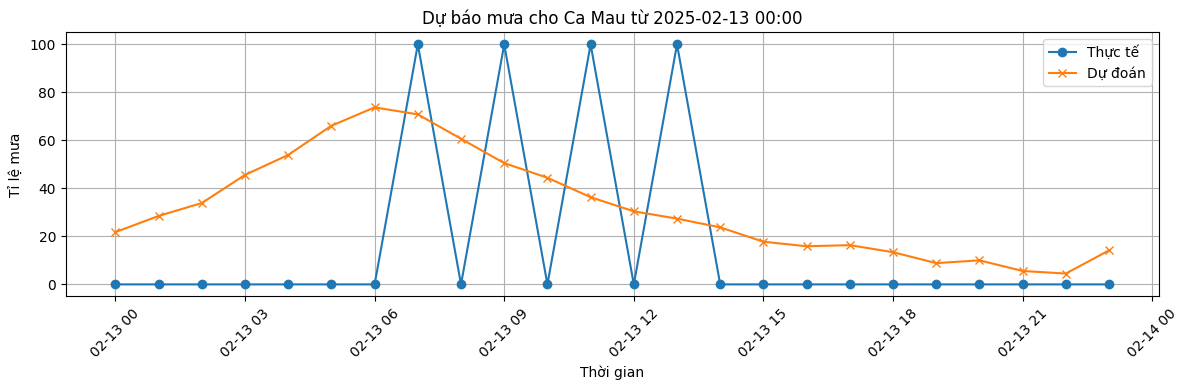

Cam Pha: MSE=1078.69, MAE=23.76%


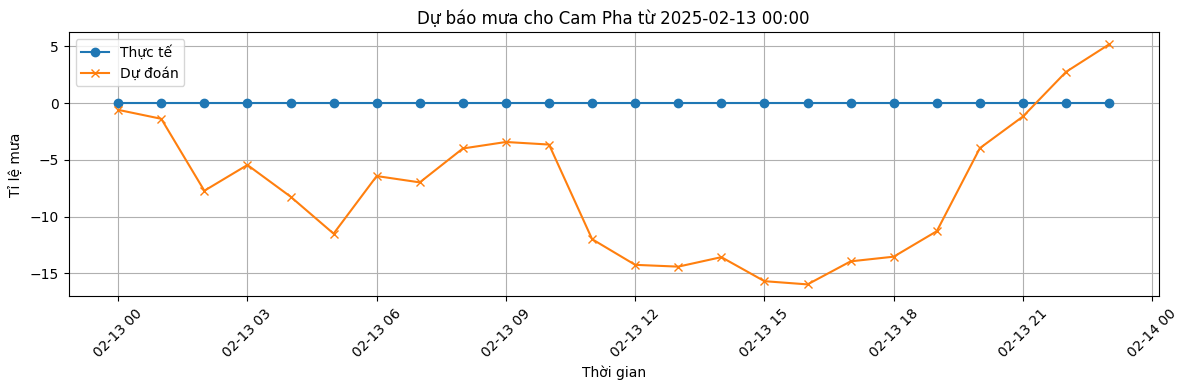

Can Tho: MSE=1095.81, MAE=24.00%


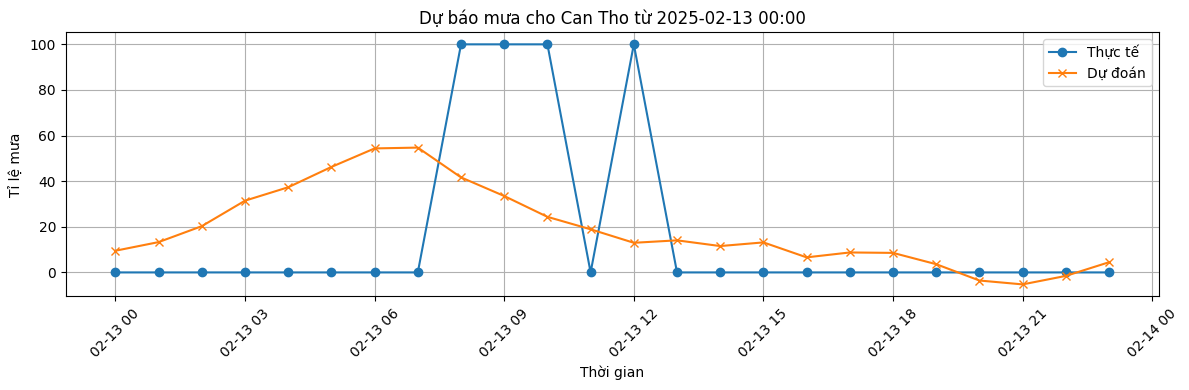

Cao Bang: MSE=1122.83, MAE=24.74%


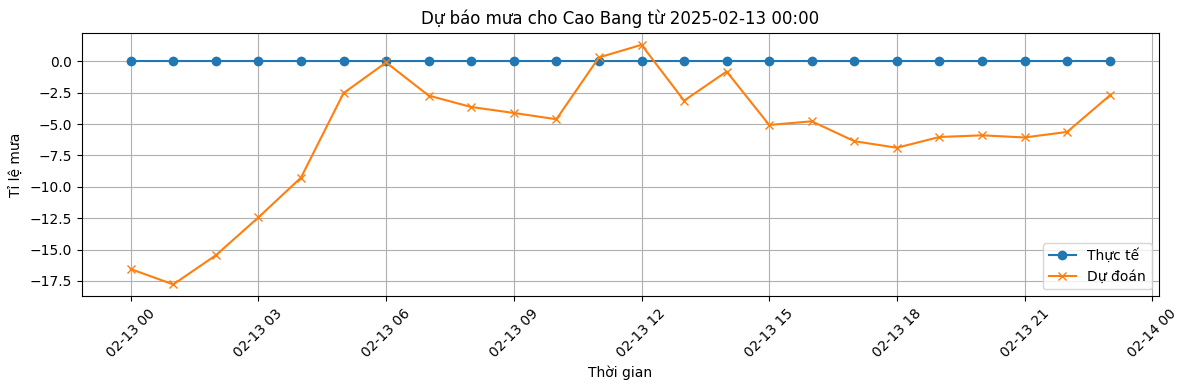

Chau Doc: MSE=1162.48, MAE=24.88%


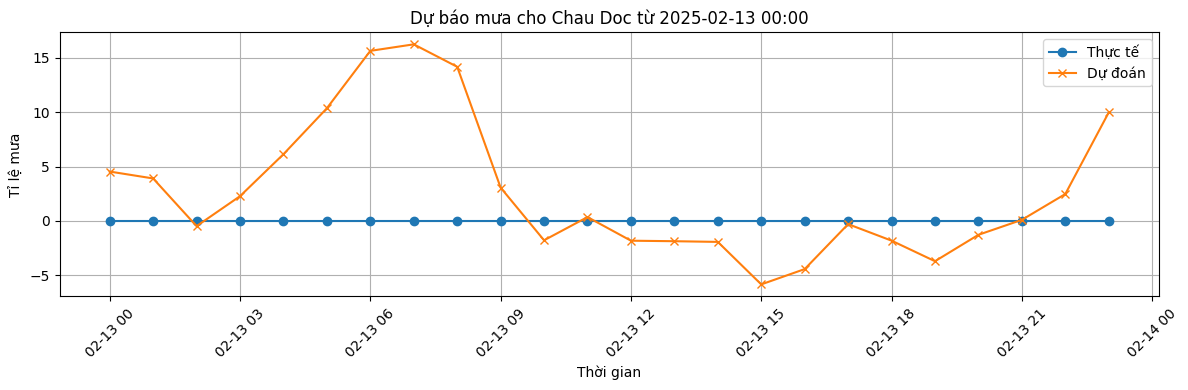

Da Lat: MSE=1007.13, MAE=22.96%


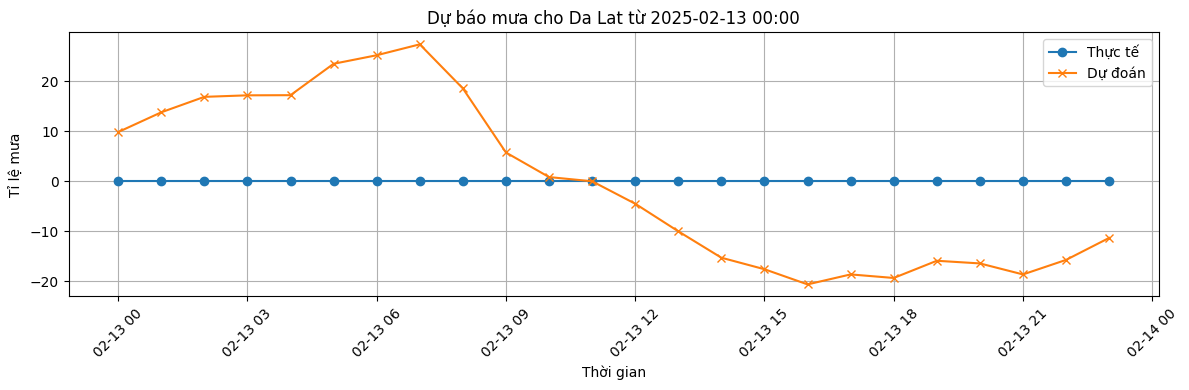

Dien Bien: MSE=999.39, MAE=22.64%


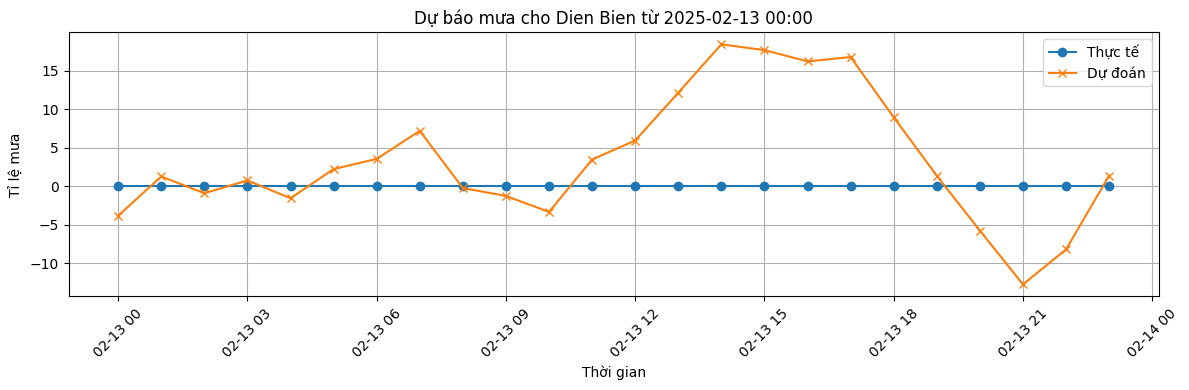

Dong Hoi: MSE=1293.76, MAE=27.82%


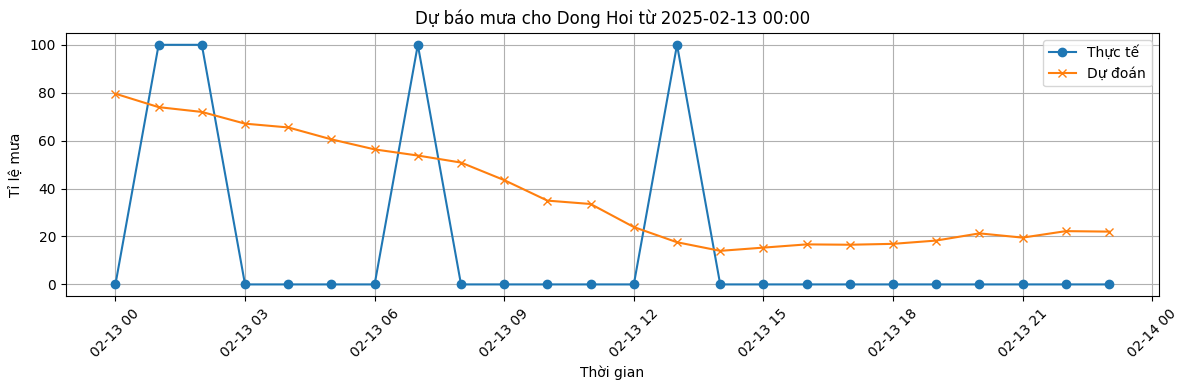

Dong Xoai: MSE=1168.46, MAE=25.06%


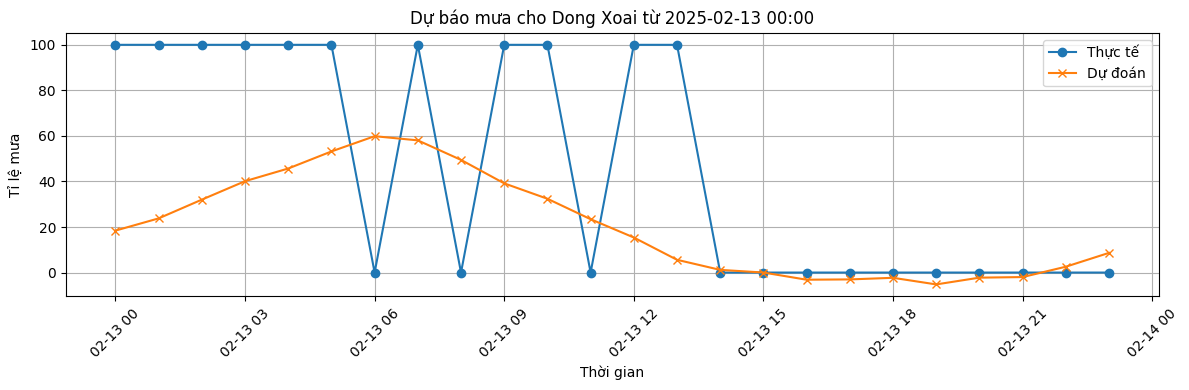

Ha Giang: MSE=1259.72, MAE=27.22%


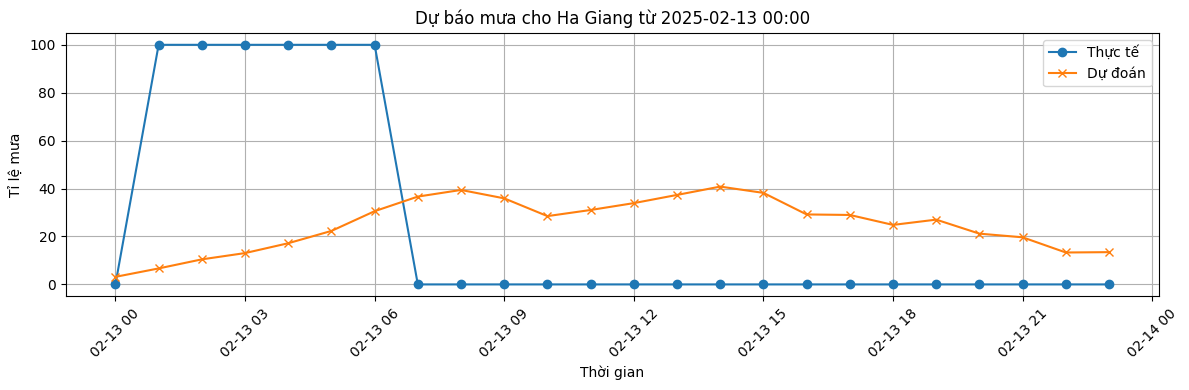

Ha Noi: MSE=959.08, MAE=21.32%


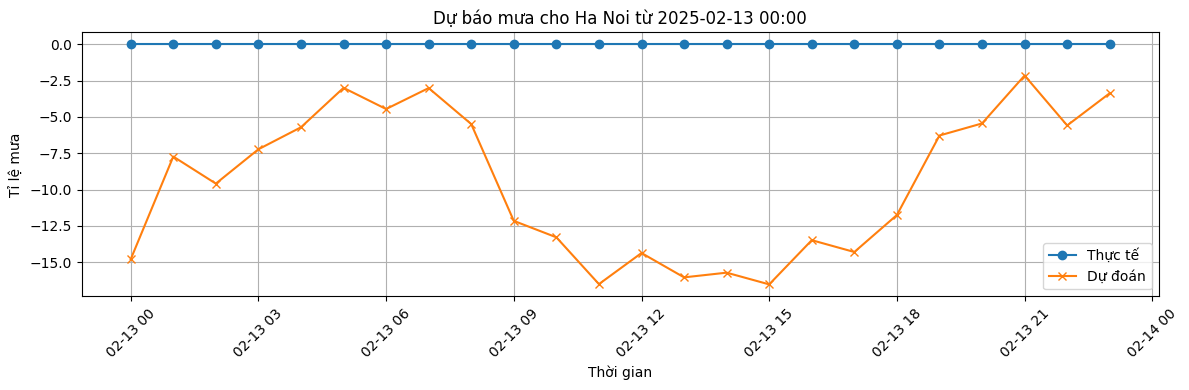

Ha Tinh: MSE=1051.58, MAE=24.14%


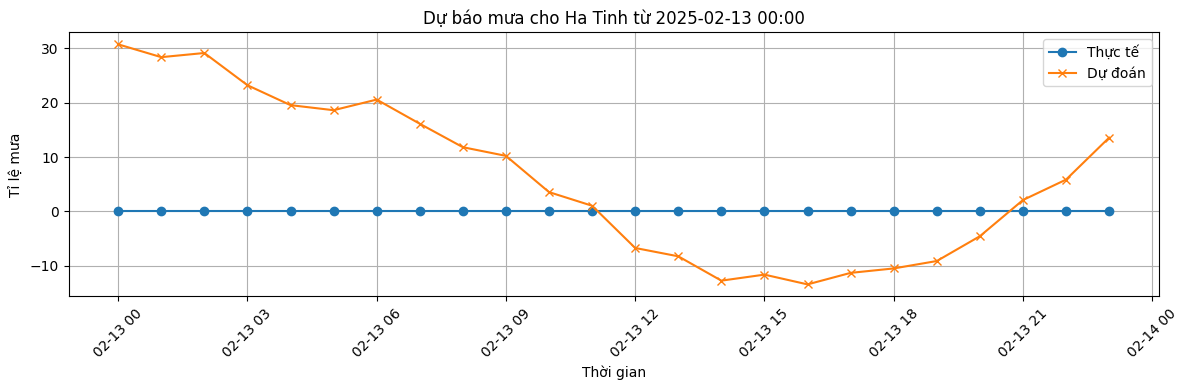

Hai Duong: MSE=913.28, MAE=21.04%


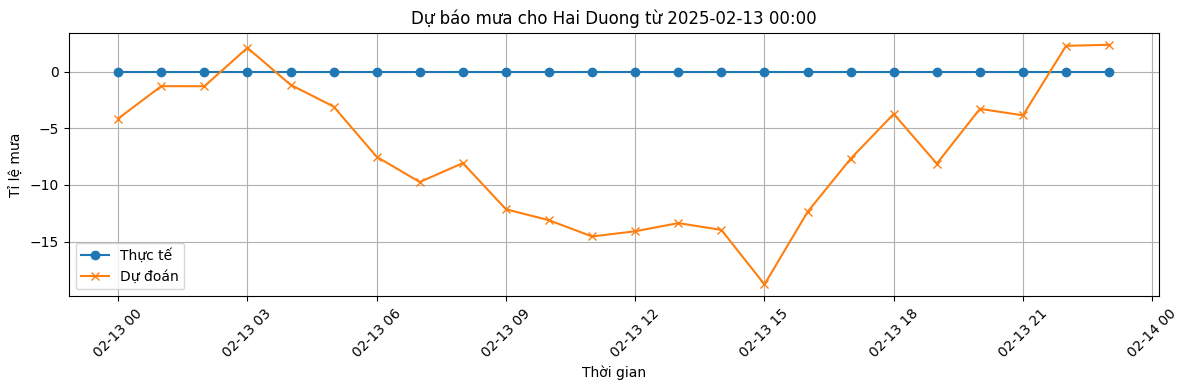

Hai Phong: MSE=894.07, MAE=20.73%


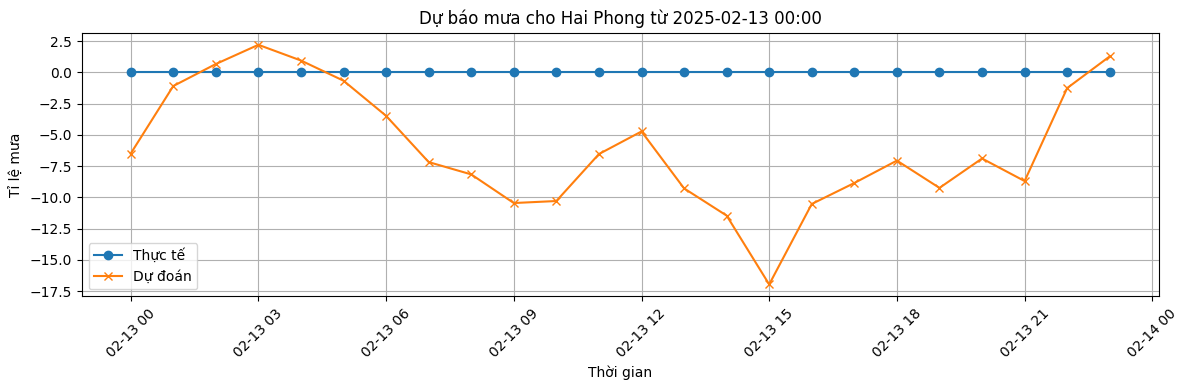

Ho Chi Minh City: MSE=1075.30, MAE=23.61%


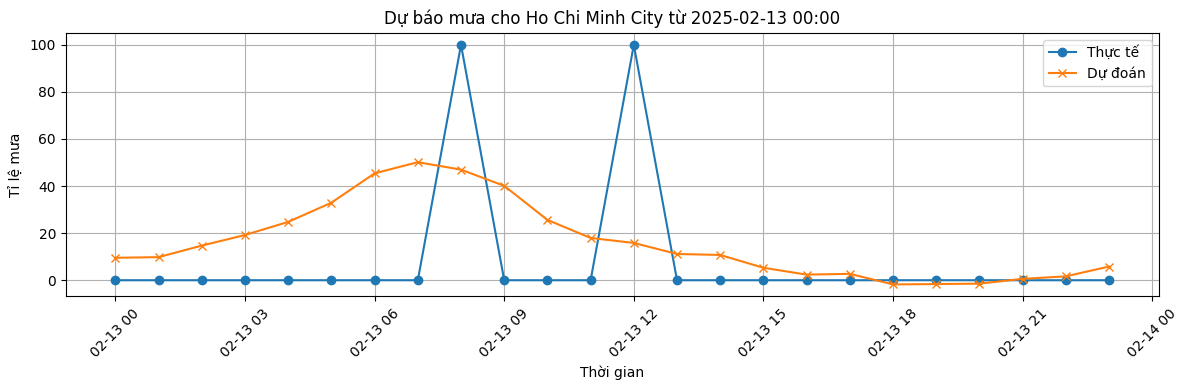

Hoa Binh: MSE=922.48, MAE=21.20%


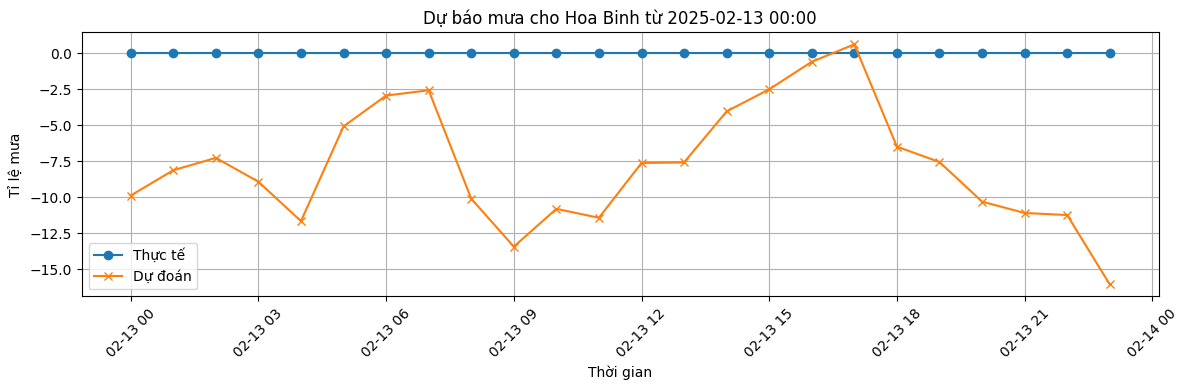

Hoi An: MSE=1172.11, MAE=26.34%


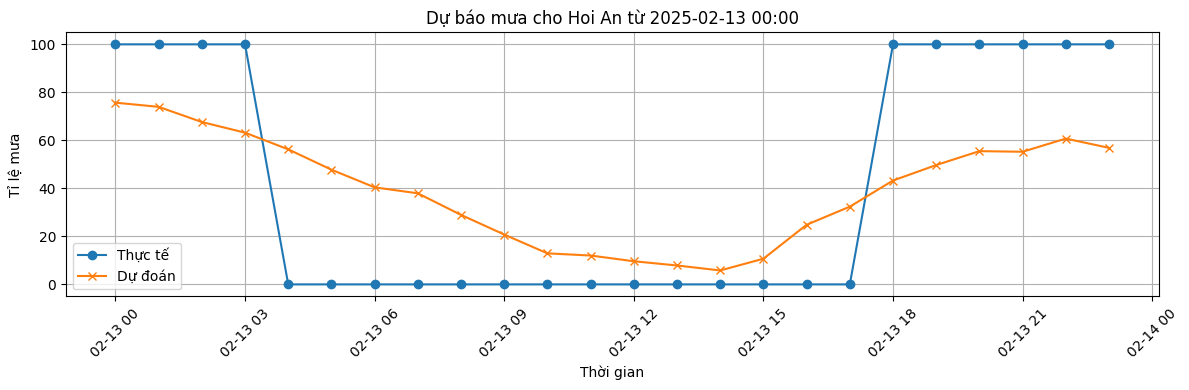

Hong-Yen: MSE=882.65, MAE=20.90%


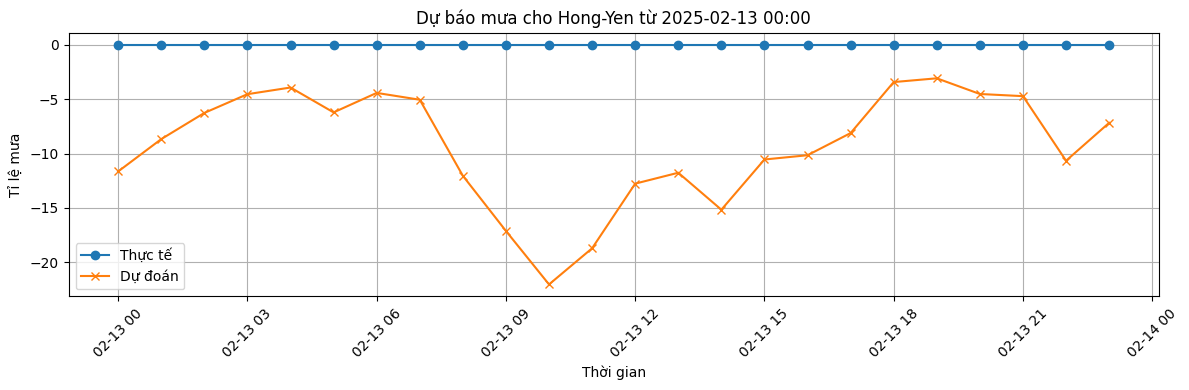

Hue: MSE=1077.21, MAE=24.76%


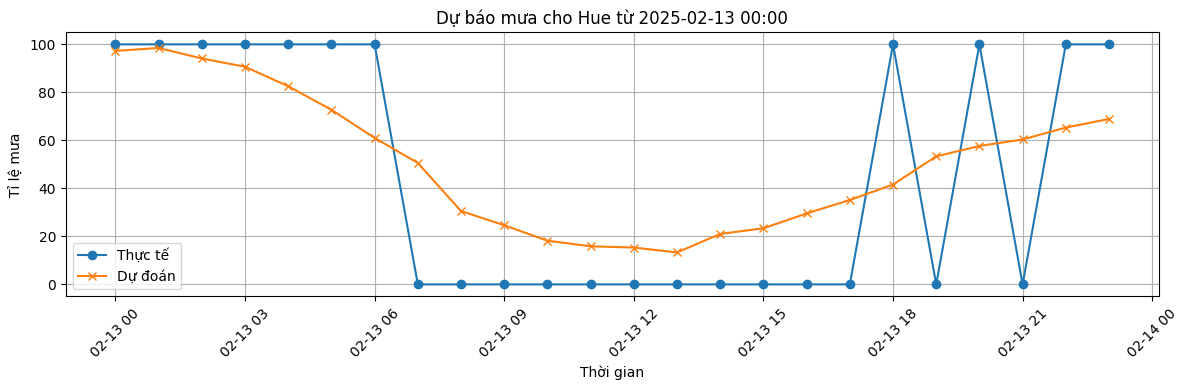

Kon Tum: MSE=954.09, MAE=21.65%


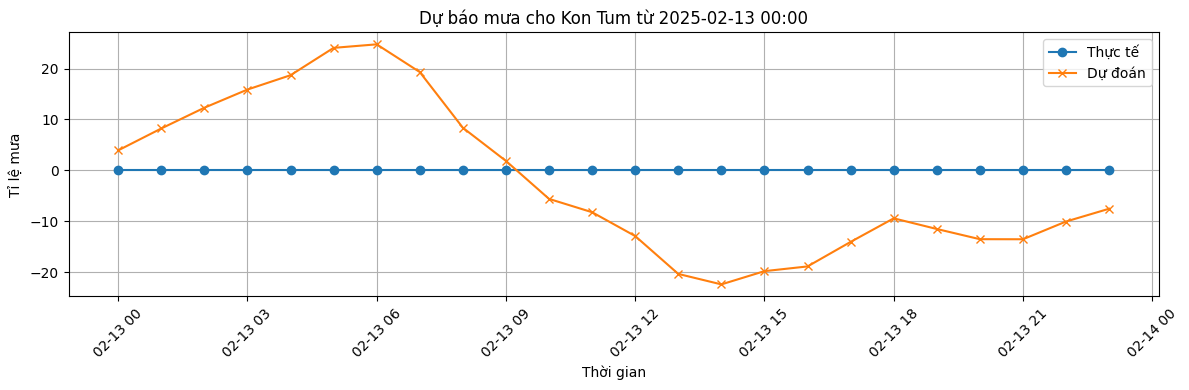

Lang Son: MSE=1026.25, MAE=22.87%


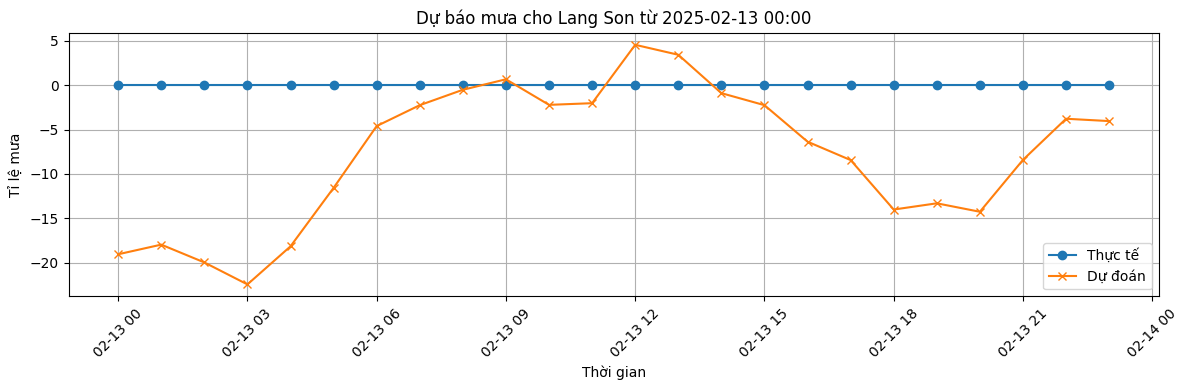

Lao Cai: MSE=1122.96, MAE=24.69%


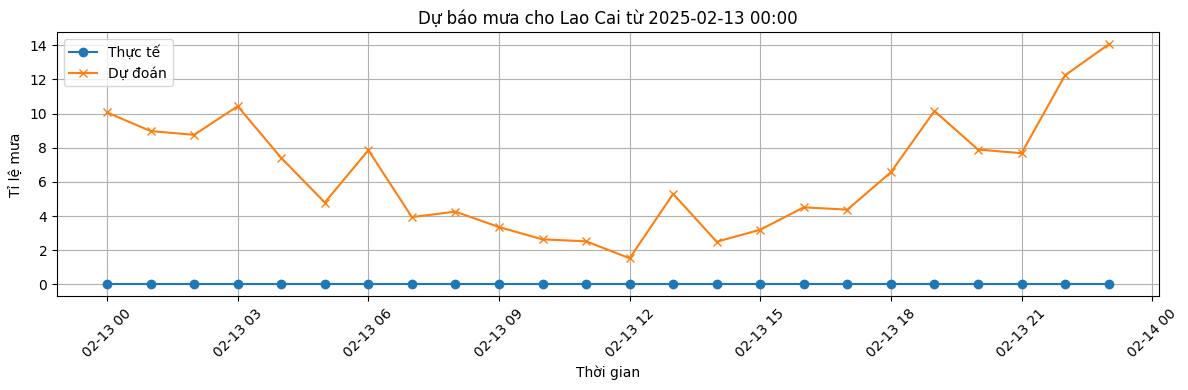

My Tho: MSE=1081.81, MAE=23.81%


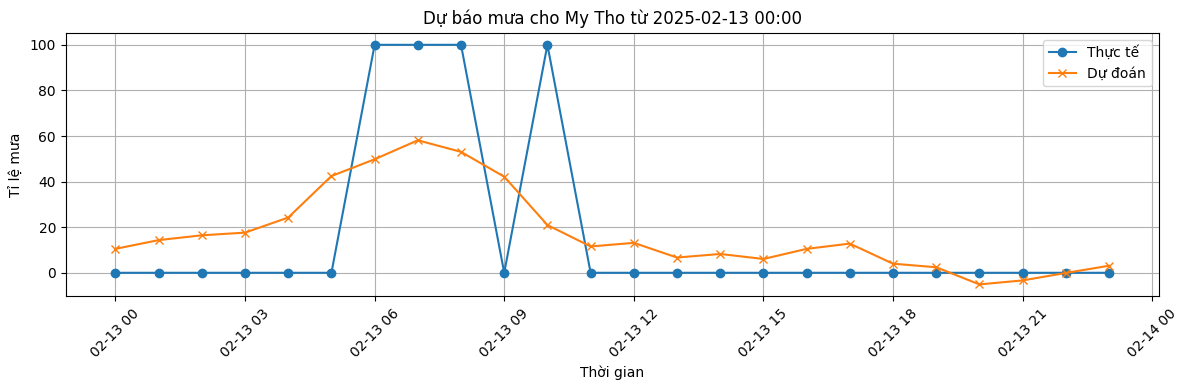

Nam Dinh: MSE=882.65, MAE=20.90%


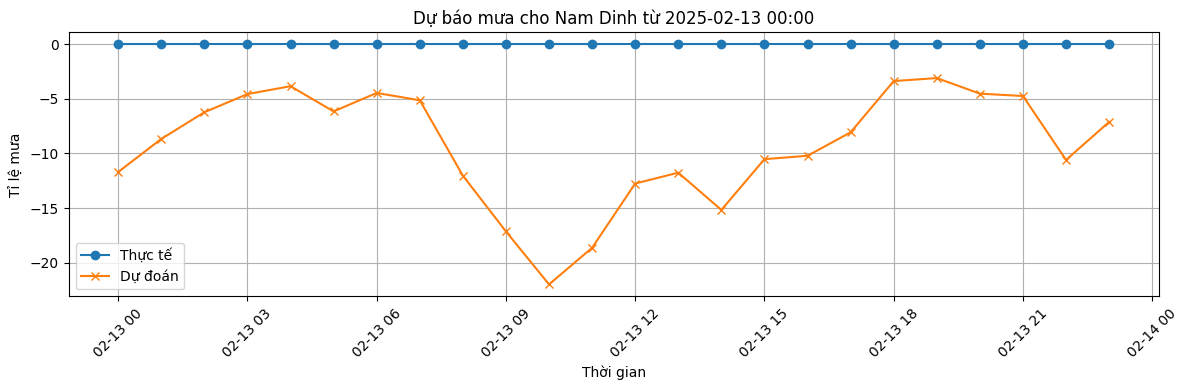

Ninh Binh: MSE=880.13, MAE=20.87%


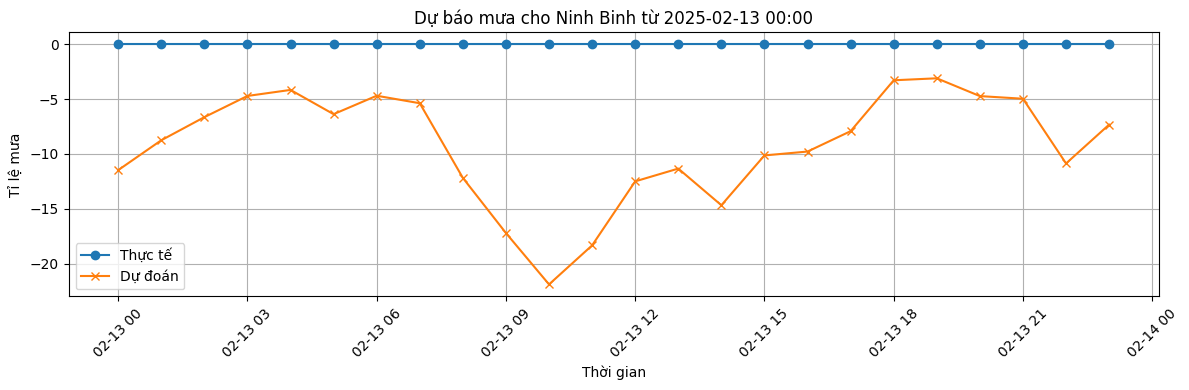

Ninh Quang: MSE=1020.54, MAE=23.00%


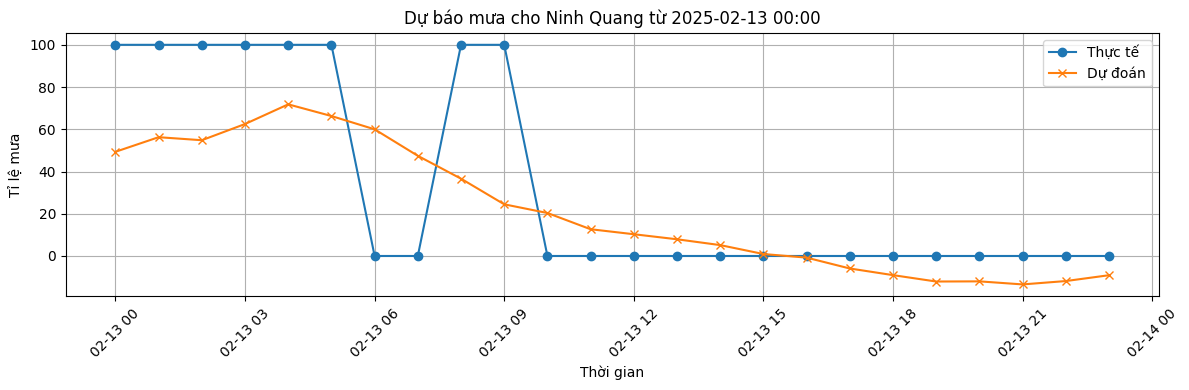

Pa Nhie: MSE=1422.74, MAE=30.42%


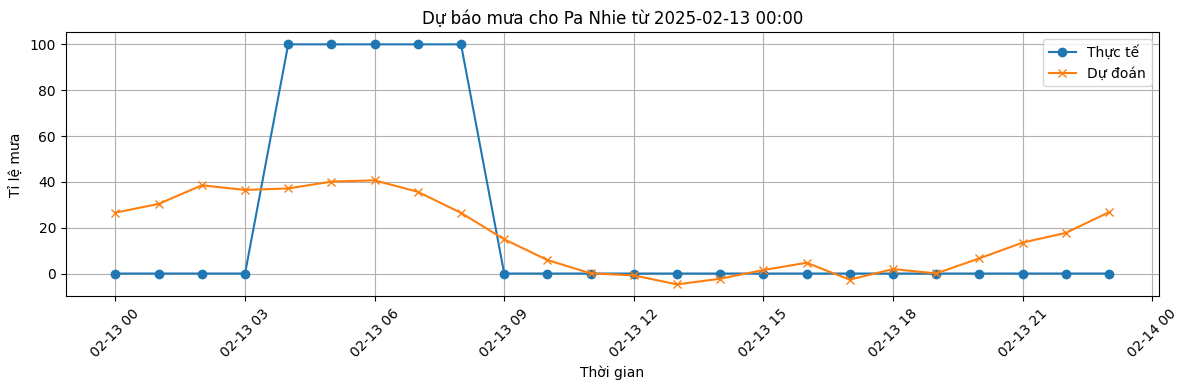

Phan Thiet: MSE=1072.17, MAE=23.06%


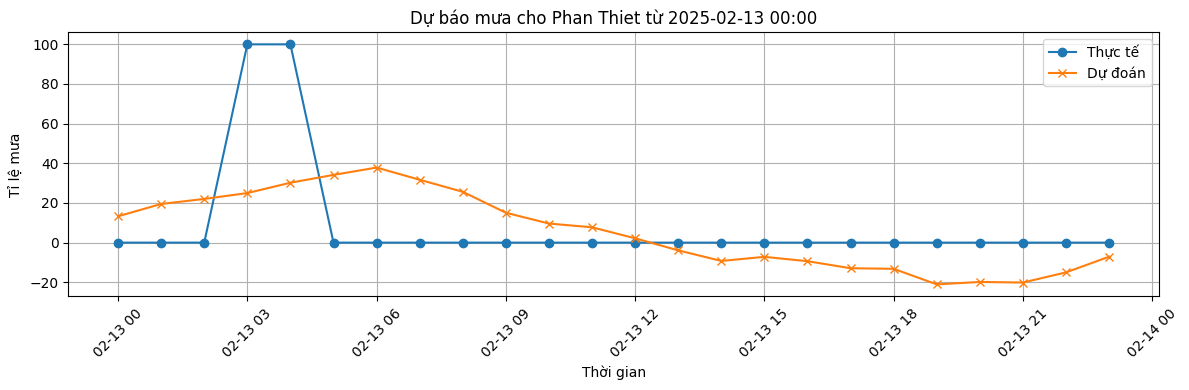

Phu Ly: MSE=882.05, MAE=20.88%


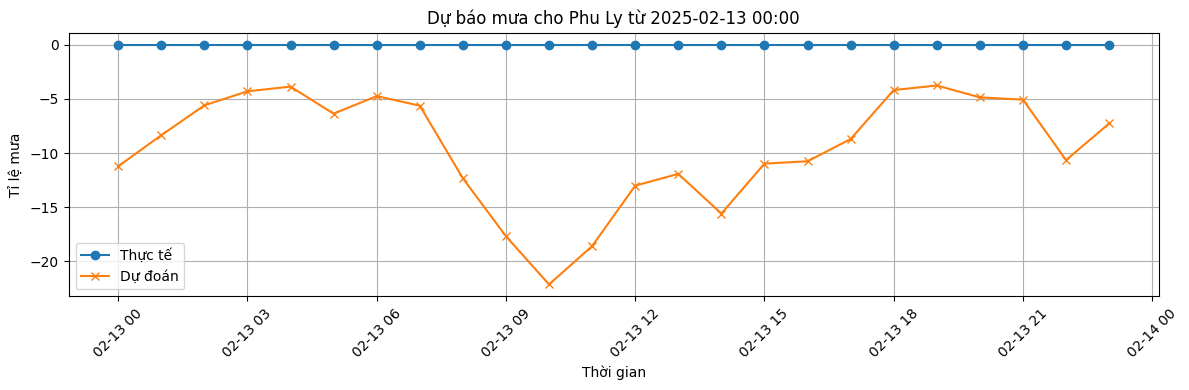

Play Cu: MSE=954.07, MAE=21.65%


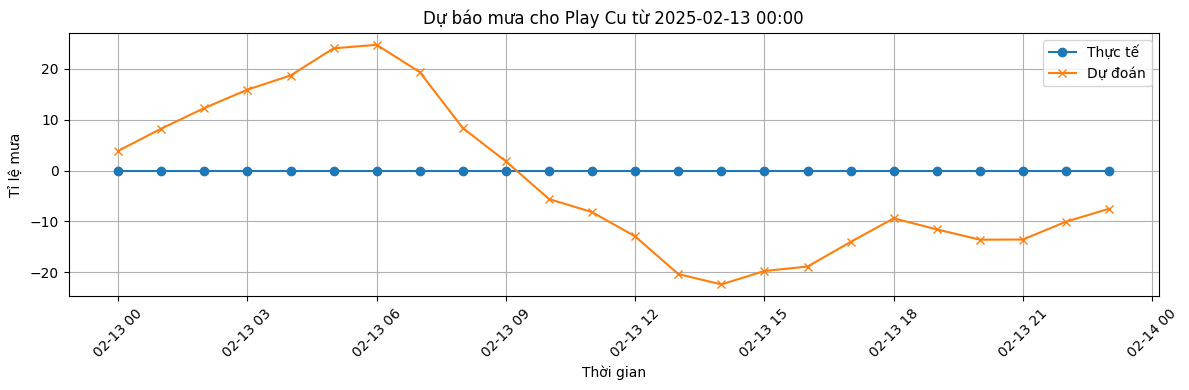

Quang Ngai: MSE=1096.88, MAE=24.92%


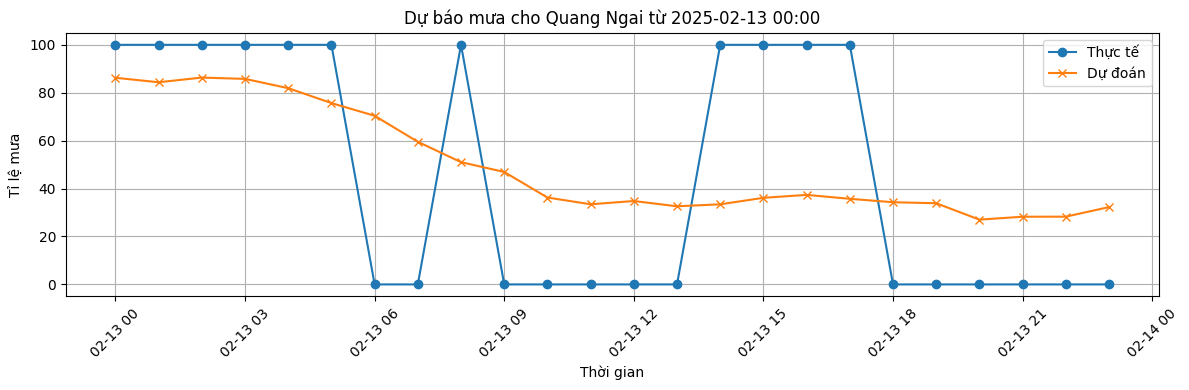

Qui Nhon: MSE=1079.80, MAE=24.50%


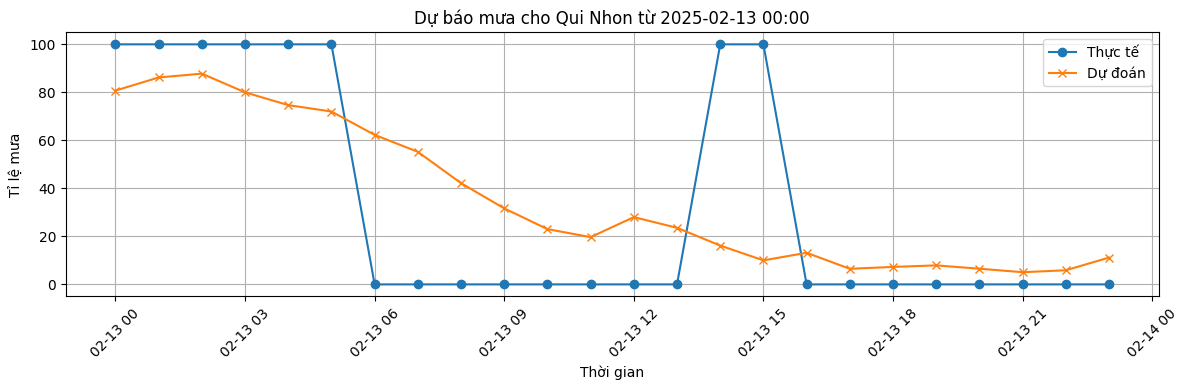

Rach Gia: MSE=1220.53, MAE=26.26%


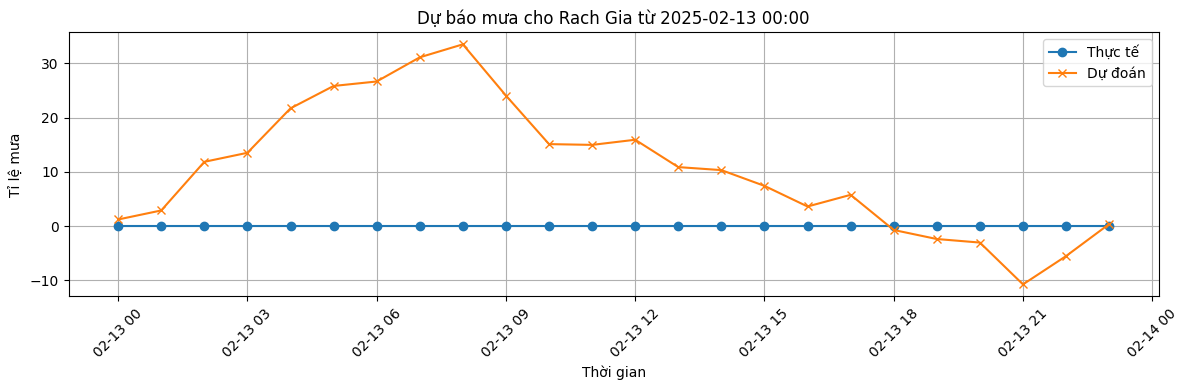

Soc Trang: MSE=1121.60, MAE=24.51%


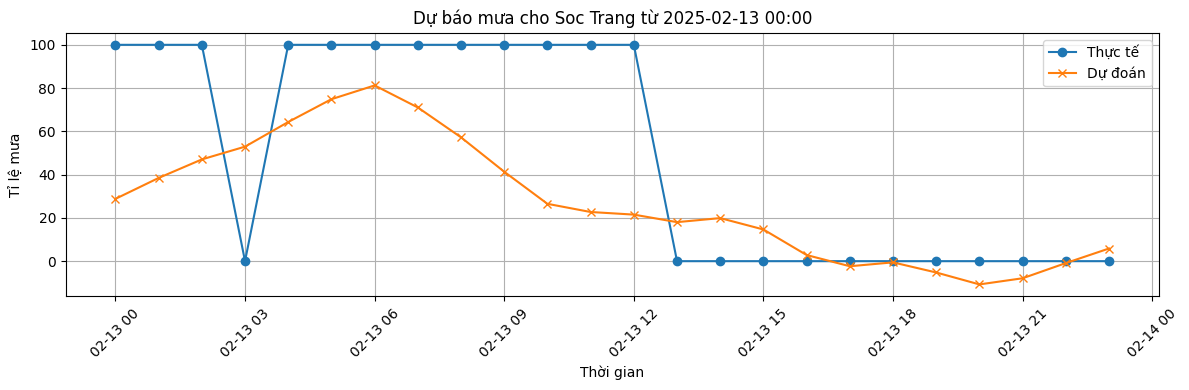

Son La: MSE=999.40, MAE=22.64%


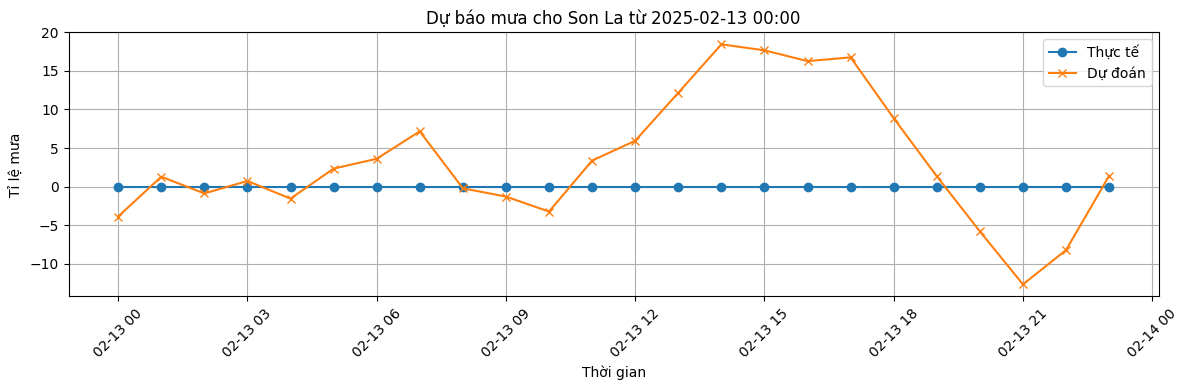

Tan An: MSE=1081.41, MAE=23.81%


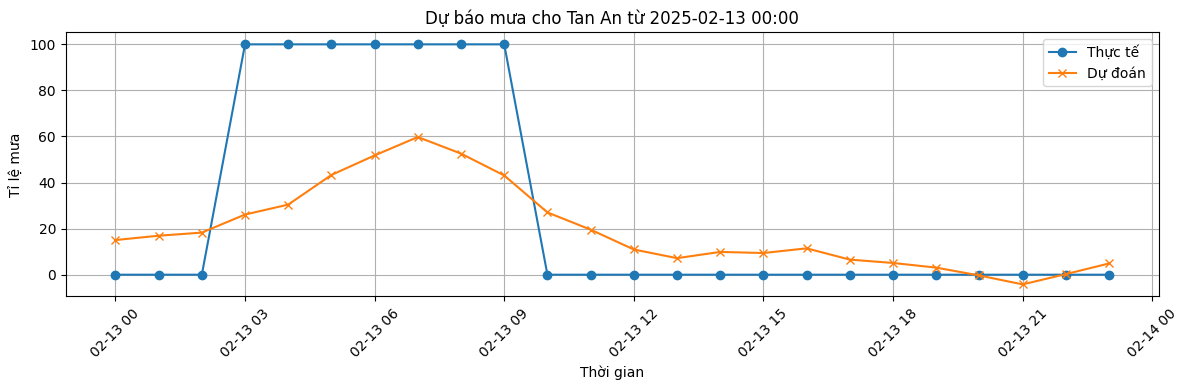

Tay Ninh: MSE=1142.97, MAE=24.51%


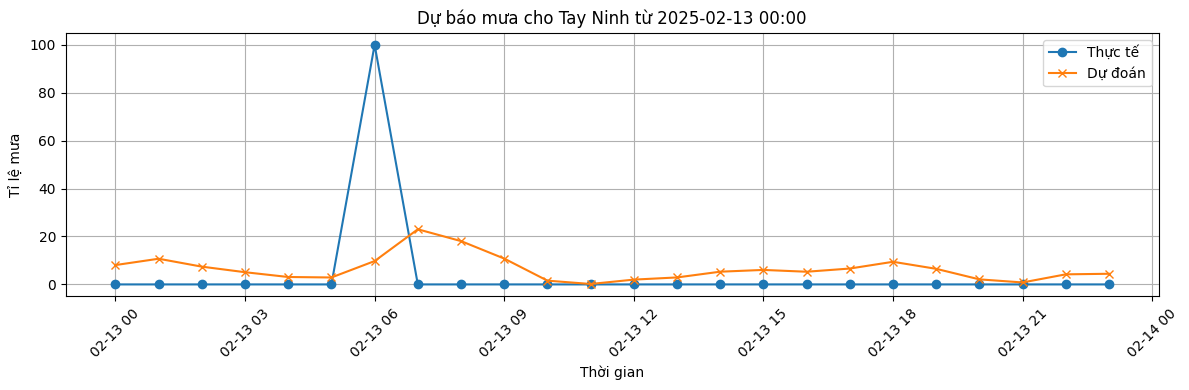

Thai Binh: MSE=895.49, MAE=20.92%


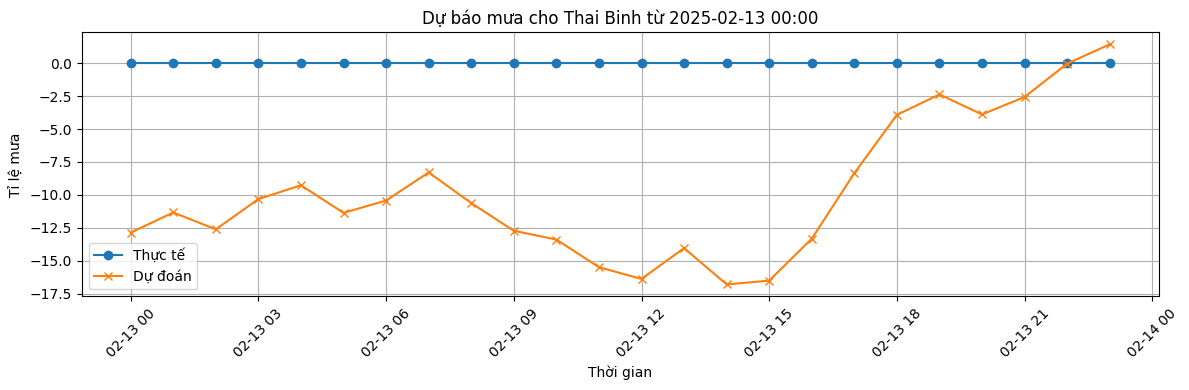

Thai Nguyen: MSE=1004.10, MAE=22.67%


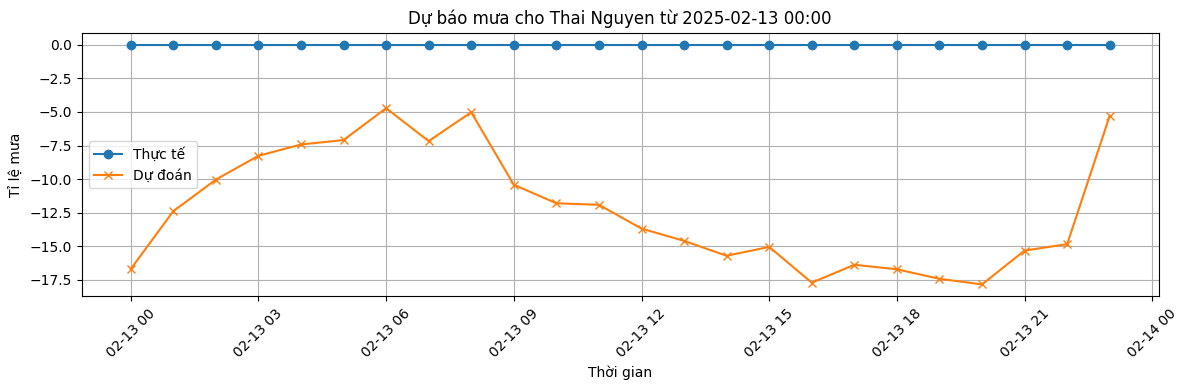

Thanh Hoa: MSE=1003.43, MAE=22.85%


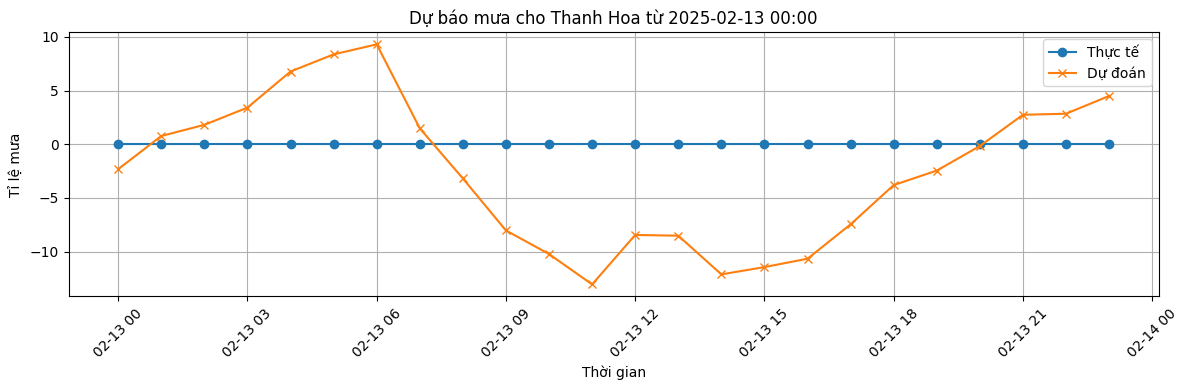

Thanh Loi: MSE=1117.92, MAE=24.25%


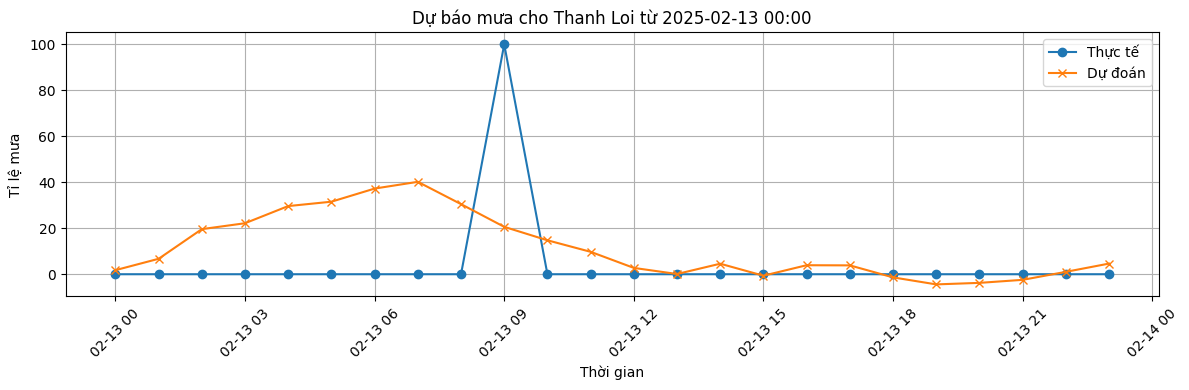

Thon Nhu Le: MSE=1077.22, MAE=24.77%


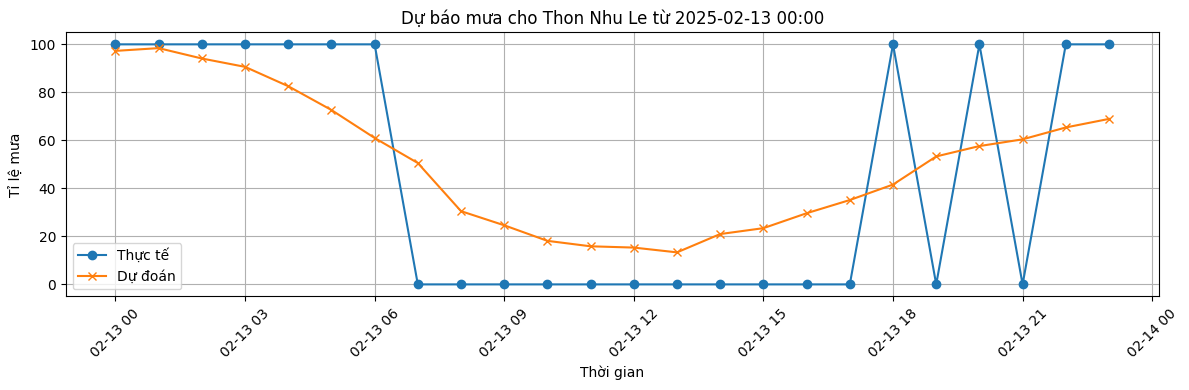

Thon Suoi La: MSE=1081.88, MAE=23.22%


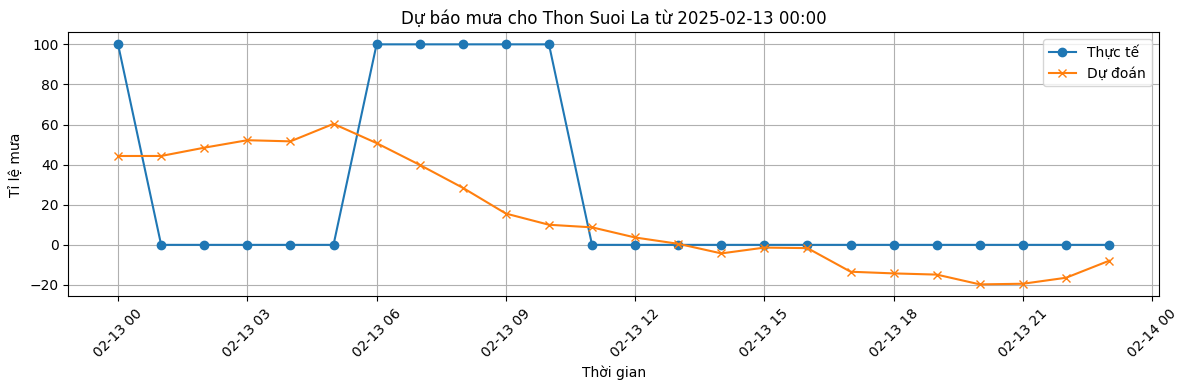

Tra Vinh: MSE=1099.95, MAE=23.89%


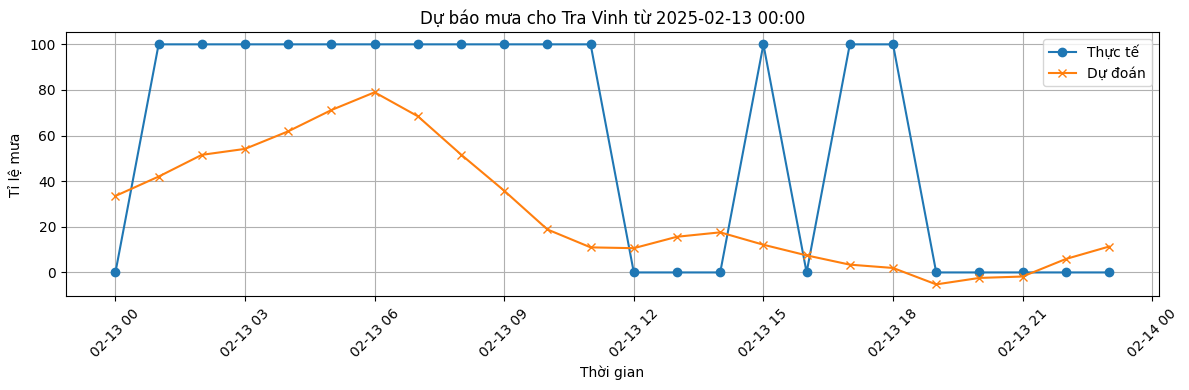

Tu Xoay: MSE=1055.39, MAE=22.92%


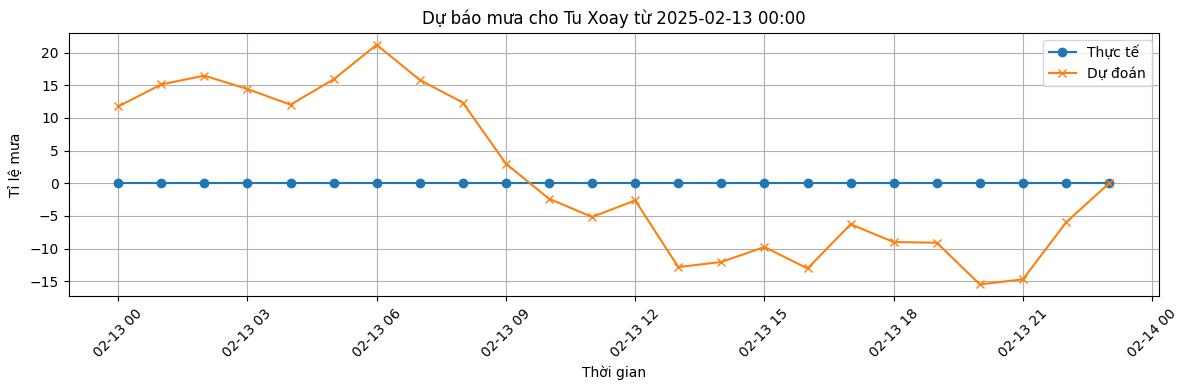

Tuyen Quang: MSE=885.94, MAE=20.42%


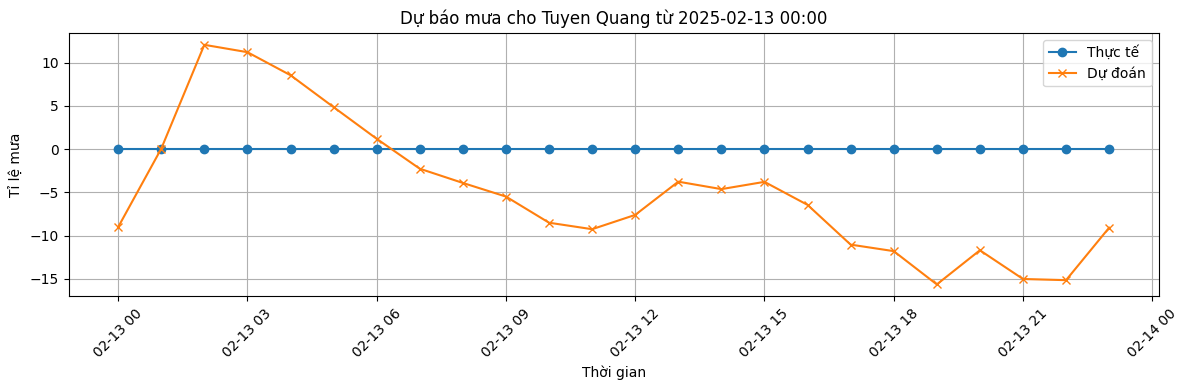

Viet Tri: MSE=884.36, MAE=20.40%


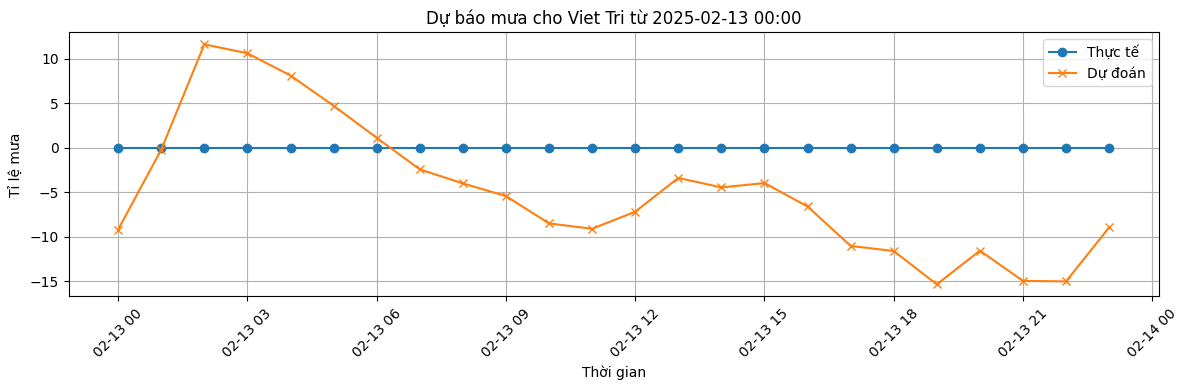

Vinh: MSE=1045.36, MAE=24.05%


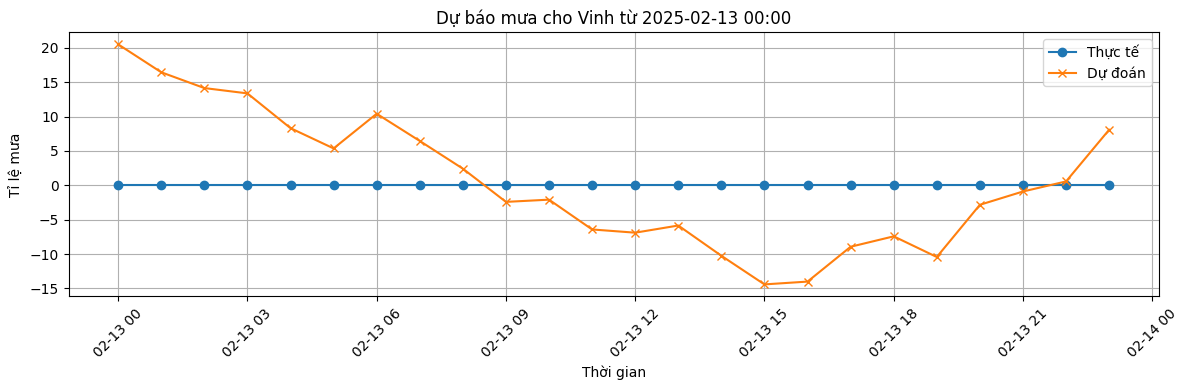

Vinh Long: MSE=1078.59, MAE=23.68%


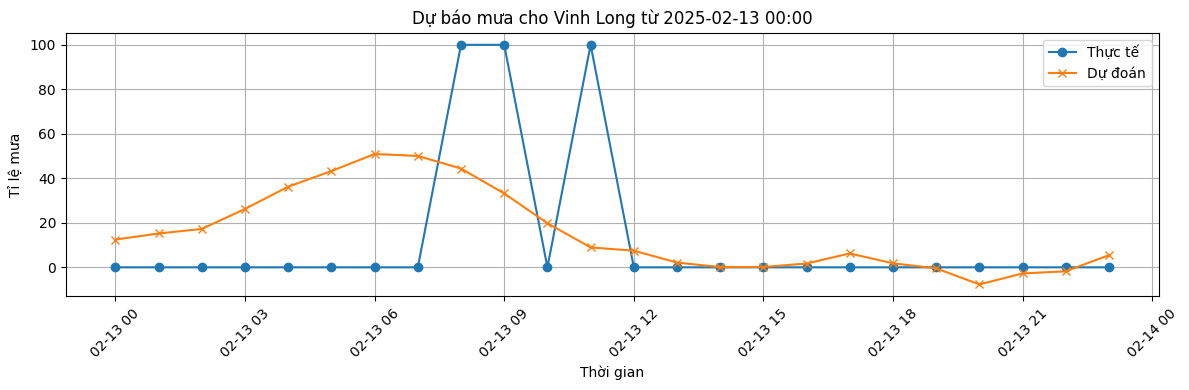

Vinh Yen: MSE=885.94, MAE=20.42%


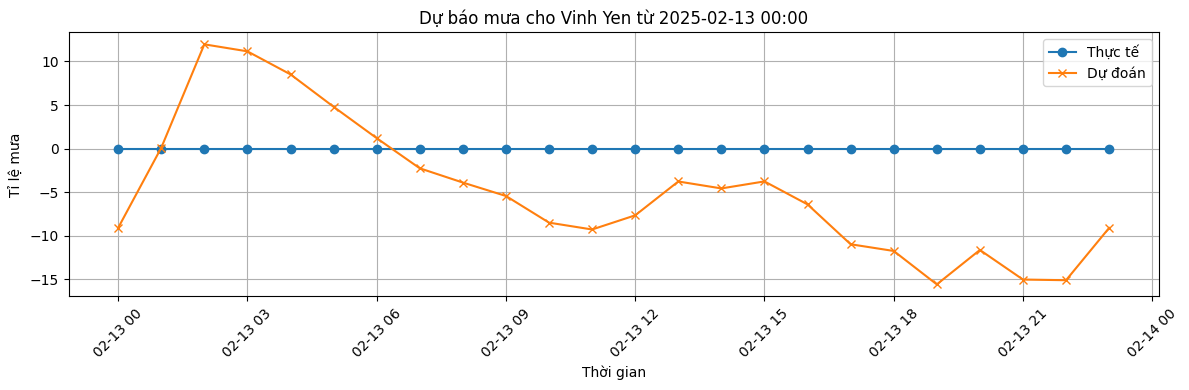

Vung Tau: MSE=1270.51, MAE=26.56%


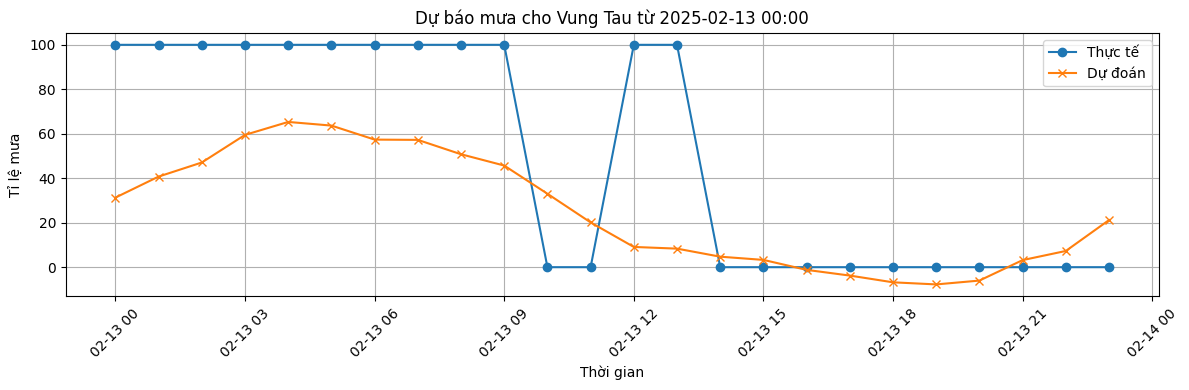

Xom Ong Ho: MSE=1075.32, MAE=23.62%


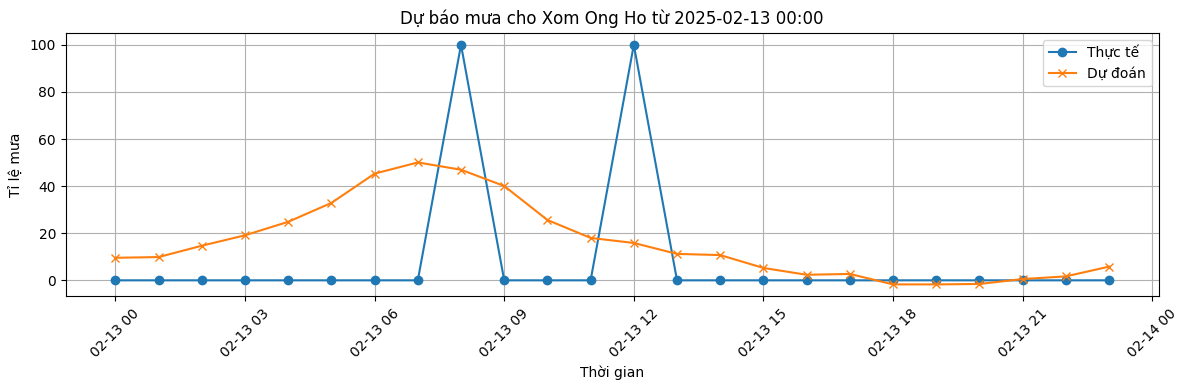

Xuan Loc Ha: MSE=1079.81, MAE=24.50%


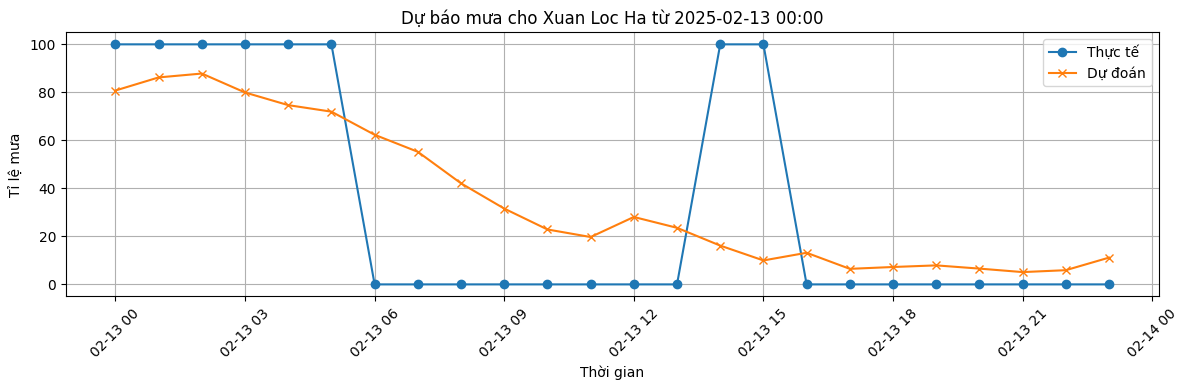

Yen Bai: MSE=885.92, MAE=20.42%


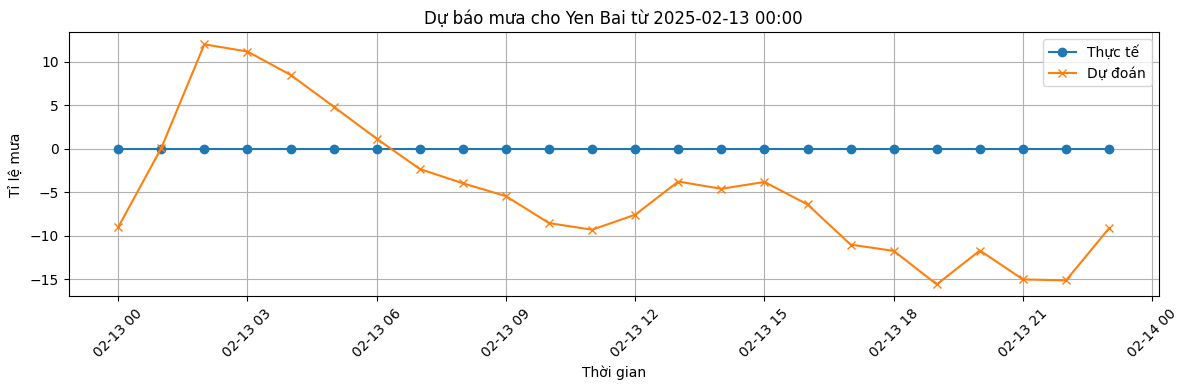

In [29]:
# [Inserted Snippet 2: Prediction and Visualization]
# Dự đoán và scale kết quả về %
predictions = model.predict(X_test) 

# Đảo ngược chuẩn hóa cho dự báo và giá trị thực
predictions_flat = predictions.reshape(-1, predictions.shape[2])
predictions_unscaled = scaler_y.inverse_transform(predictions_flat)
predictions_unscaled = predictions_unscaled.reshape(predictions.shape)

y_test_flat = y_test.reshape(-1, y_test.shape[2])
y_test_unscaled = scaler_y.inverse_transform(y_test_flat)
y_test_unscaled = y_test_unscaled.reshape(y_test.shape)

# Lấy danh sách tỉnh
province_names = sorted(df_rain.select("location_name").distinct().rdd.flatMap(lambda x: x).collect())[:63]

# Đánh giá và trực quan hóa
for i, province in enumerate(province_names):
    actual = y_test_unscaled[:, :, i]
    pred = predictions_unscaled[:, :, i]
    
    mse = np.mean((actual - pred) ** 2)
    mae = np.mean(np.abs(actual - pred))
    print(f"{province}: MSE={mse:.2f}, MAE={mae:.2f}%")
    
    start_time = pd.to_datetime(ts_data.index[-len(X_test):][0])
    forecast_times = pd.date_range(start=start_time, periods=24, freq='H')
    
    plt.figure(figsize=(12, 4))
    plt.plot(forecast_times, actual[0], label='Thực tế', marker='o')
    plt.plot(forecast_times, pred[0], label='Dự đoán', marker='x')
    plt.title(f'Dự báo mưa cho {province} từ {start_time.strftime("%Y-%m-%d %H:%M")}')
    plt.xlabel('Thời gian')
    plt.ylabel('Tỉ lệ mưa')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    plt.show()
    plt.close()

In [31]:
from pyspark.sql.functions import col, abs, pow, sqrt, lit
from pyspark.sql import functions as F

# Example: Add a dummy predicted_chance_of_rain column (replace with actual model predictions)
df_rain = df.withColumn("predicted_chance_of_rain", lit(0))  # Dummy column with 0s; replace with model output

# Calculate MAE
mae = df_rain.select(F.avg(abs(col("chance_of_rain") - col("predicted_chance_of_rain"))).alias("mae")).collect()[0]["mae"]

# Calculate RMSE
rmse = df_rain.select(sqrt(F.avg(pow(col("chance_of_rain") - col("predicted_chance_of_rain"), 2))).alias("rmse")).collect()[0]["rmse"]

print(f"MAE for rain prediction: {mae:.4f}")
print(f"RMSE for rain prediction: {rmse:.4f}")

MAE for rain prediction: 28.0430
RMSE for rain prediction: 52.7394
